# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (uti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_uti_admitted', 'duration_uti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + uti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_uti/data_uti_record_cph_uti.txt", "w")
a.write("")
a.writelines(['data_uti_1 #with a record, #with no record: %.0f' % (data['uti_date_1'].notna().sum()), ', %.0f' % (data['uti_date_1'].isna().sum()),
              '\ndata_uti_2 #with a record, #with no record: %.0f' % (data['uti_date_2'].notna().sum()), ', %.0f' % (data['uti_date_2'].isna().sum()),
              '\ndata_uti_3 #with a record, #with no record: %.0f' % (data['uti_date_3'].notna().sum()), ', %.0f' % (data['uti_date_3'].isna().sum()),
              '\ndata_uti_4 #with a record, #with no record: %.0f' % (data['uti_date_4'].notna().sum()), ', %.0f' % (data['uti_date_4'].isna().sum()),
              '\ndata_uti_5 #with a record, #with no record: %.0f' % (data['uti_date_5'].notna().sum()), ', %.0f' % (data['uti_date_5'].isna().sum()),
              '\ndata_uti_6 #with a record, #with no record: %.0f' % (data['uti_date_6'].notna().sum()), ', %.0f' % (data['uti_date_6'].isna().sum()),
              '\ndata_uti_7 #with a record, #with no record: %.0f' % (data['uti_date_7'].notna().sum()), ', %.0f' % (data['uti_date_7'].isna().sum()),
              '\ndata_uti_8 #with a record, #with no record: %.0f' % (data['uti_date_8'].notna().sum()), ', %.0f' % (data['uti_date_8'].isna().sum()),
              '\ndata_uti_9 #with a record, #with no record: %.0f' % (data['uti_date_9'].notna().sum()), ', %.0f' % (data['uti_date_9'].isna().sum()),
              '\ndata_uti_10 #with a record, #with no record: %.0f' % (data['uti_date_10'].notna().sum()), ', %.0f' % (data['uti_date_10'].isna().sum()),
              '\ndata_uti_11 #with a record, #with no record: %.0f' % (data['uti_date_11'].notna().sum()), ', %.0f' % (data['uti_date_11'].isna().sum()),
              '\ndata_uti_12 #with a record, #with no record: %.0f' % (data['uti_date_12'].notna().sum()), ', %.0f' % (data['uti_date_12'].isna().sum()),
              '\ndata_uti_13 #with a record, #with no record: %.0f' % (data['uti_date_13'].notna().sum()), ', %.0f' % (data['uti_date_13'].isna().sum()),
              '\ndata_uti_14 #with a record, #with no record: %.0f' % (data['uti_date_14'].notna().sum()), ', %.0f' % (data['uti_date_14'].isna().sum()),
              '\ndata_uti_15 #with a record, #with no record: %.0f' % (data['uti_date_15'].notna().sum()), ', %.0f' % (data['uti_date_15'].isna().sum()),
              '\ndata_uti_16 #with a record, #with no record: %.0f' % (data['uti_date_16'].notna().sum()), ', %.0f' % (data['uti_date_16'].isna().sum()),
              '\ndata_uti_17 #with a record, #with no record: %.0f' % (data['uti_date_17'].notna().sum()), ', %.0f' % (data['uti_date_17'].isna().sum()),
              '\ndata_uti_18 #with a record, #with no record: %.0f' % (data['uti_date_18'].notna().sum()), ', %.0f' % (data['uti_date_18'].isna().sum()),
              '\ndata_uti_19 #with a record, #with no record: %.0f' % (data['uti_date_19'].notna().sum()), ', %.0f' % (data['uti_date_19'].isna().sum()),
              '\ndata_uti_20 #with a record, #with no record: %.0f' % (data['uti_date_20'].notna().sum()), ', %.0f' % (data['uti_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37086
1.0     36848
2.0     33172
3.0     24767
4.0     15065
6.0     12394
7.0      9850
5.0      8275
8.0      8174
9.0      5627
10.0     3292
11.0     1869
12.0     1358
13.0      861
14.0      613
15.0      370
16.0      175
17.0      108
18.0       57
19.0       27
20.0        7
21.0        3
23.0        1
22.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 12 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(216208, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] #gp_cons_uti
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')
print(f'min date: {data_uti.date.min()}')
print(f'max date: {data_uti.date.max()}')
print(f'length of data_uti: {len(data_uti)}')

min date: 2019-01
max date: 2022-11
length of data_uti: 216208


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

print(data_uti['season'].value_counts())
print(f'\nmin date: {data_uti.date.min()}')
print(f'max date: {data_uti.date.max()}')
print(f'length: {len(data_uti)}')

spring    56411
summer    56106
winter    49946
autumn    41843
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 204306


In [24]:
# data_uti = data_uti[data_uti['date'] <= '2019-12']
# data_uti = data_uti[(data_uti['date'] >= '2020-03') & (data_uti['date']<= '2021-03')]
# data_uti = data_uti[data_uti['date'] >= '2021-04']
# print(f'min date: {data_uti.date.min()}')
# print(f'max date: {data_uti.date.max()}')

#### event and duration

In [25]:
#scenario 1
#not hosped (nothing happened)
#data_uti = data_uti[data_uti['admitted_uti_date'].notnull()]
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0
data_uti['event_uti_admitted'].value_counts()

0.0    142796
Name: event_uti_admitted, dtype: int64

In [26]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days #gp_cons_uti
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1
# data_uti['event_uti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]
data_uti['delta_uti_admitted'].value_counts()

109.0     58
19.0      55
220.0     55
96.0      55
245.0     55
          ..
1397.0     1
1371.0     1
1250.0     1
1334.0     1
1314.0     1
Name: delta_uti_admitted, Length: 1382, dtype: int64

In [27]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_uti.loc[data_uti['delta_admitted_died'] >= 0, 'event_uti_admitted'] = 0
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0
# data_uti['event_uti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_uti.loc[data_uti['delta_admitted_deregistered'] >= 0, 'event_uti_admitted'] = 0
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0
# data_uti['event_uti_admitted'].value_counts()

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_uti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

172147

In [28]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)
data_uti['event_uti_admitted'].value_counts()

0.0    173923
1.0      1341
Name: event_uti_admitted, dtype: int64

In [29]:
#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30
data_uti['duration_uti_admitted'].value_counts()

30.0    173965
19.0        55
29.0        55
24.0        52
20.0        50
18.0        49
21.0        49
13.0        49
12.0        48
2.0         48
0.0         47
7.0         47
22.0        46
14.0        45
26.0        44
17.0        44
15.0        43
9.0         42
25.0        42
8.0         42
1.0         39
4.0         39
6.0         39
16.0        39
5.0         38
11.0        37
27.0        37
23.0        36
3.0         36
28.0        34
10.0        28
Name: duration_uti_admitted, dtype: int64

In [30]:
# give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1
data_uti['event_uti_admitted'].value_counts()

0.0    173918
1.0      1346
Name: event_uti_admitted, dtype: int64

In [31]:
#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

In [32]:
# data_uti[data_uti['duration_uti_admitted']==0][['delta_uti_admitted', 'uti_date', 'gp_cons_uti', 'admitted_uti_date', 'delta_uti_admitted', 'delta_admitted_died_deregistered', 'event_uti_admitted', 'duration_uti_admitted']]
# data_uti.loc[151:200, ['event_uti_admitted', 'duration_uti_admitted']]
# data_uti.loc[201:250, ['event_uti_admitted', 'duration_uti_admitted']].sort_values(by=['duration_uti_admitted'])
data_uti[['event_uti_admitted', 'duration_uti_admitted']].sort_values(by=['duration_uti_admitted'])

,event_uti_admitted,duration_uti_admitted
166050,1.0,1.0
180893,1.0,1.0
114834,1.0,1.0
34570,1.0,1.0
145457,1.0,1.0
...,...,...
72348,0.0,30.0
72349,0.0,30.0
72350,0.0,30.0
72339,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [33]:
# prep before plot
data_uti['age'][data_uti['age'] < 0] = np.nan
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_uti = data_uti[~(data_uti['age'] < 18)]  
print(f'Min age: {data_uti.age.min()}')

## remove died cases
#data_uti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
# replace 0s with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [34]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking_status": dict_smoking})

In [35]:
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_uti['region_imp'] = data_uti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_uti.region.isnull().sum()}')
    data_uti = data_uti[data_uti['region'].notna()]

print(f'Cound of missing values in variable region: {data_uti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_uti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21345
South East                  10759
South West                  10701
North East                  10693
East                        10637
West Midlands               10604
East Midlands               10590
Yorkshire and The Humber    10557
North West                  10465
Name: region, dtype: int64


In [36]:
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_uti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_uti.antibacterial_brit.mean():.3f}')
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)
    # data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_uti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_uti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 5
Mean of antibacterial_brit values before changing NAN to zeros: 1.257

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.257


In [37]:
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_uti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_uti.ethnicity.value_counts()}')
    # data_uti['ethnicity'] = data_uti['ethnicity'].astype(str)
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_uti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_uti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26855
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    63520
3.0     8129
5.0     7847
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    63520
0.0    26855
3.0     8129
5.0     7847
Name: ethnicity, dtype: int64


In [38]:
if ('smoking_status' in data_uti.columns) and (data_uti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_uti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_uti.smoking_status.value_counts()}')
    # data_uti['smoking_status'] = data_uti['smoking_status'].astype(str)
    data_uti['smoking_status'] = data_uti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_uti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_uti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 44144
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    41383
3.0    13926
2.0     6898
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    44144
1.0    41383
3.0    13926
2.0     6898
Name: smoking_status, dtype: int64


In [39]:
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_uti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_uti.imd.value_counts()}')
    # data_uti['imd'] = data_uti['imd'].astype(str)
    data_uti['imd'] = data_uti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_uti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_uti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
5    20460
1    20307
4    20197
2    20090
3    20011
0     5286
Name: imd, dtype: int64


In [40]:
data_uti['bmi_cat'] = 5
col_bmi_cat = data_uti.columns.get_loc('bmi_cat')

col_sex = data_uti.columns.get_loc('sex')
col_age = data_uti.columns.get_loc('age')
col_bmi = data_uti.columns.get_loc('bmi')

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, col_bmi] >= 30:
        data_uti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_uti.iat[idx, col_bmi] >= 25) and (data_uti.iat[idx, col_bmi] < 30):
        data_uti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_uti.iat[idx, col_bmi] >= 18.5) and (data_uti.iat[idx, col_bmi] < 25):
        data_uti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_uti.iat[idx, col_bmi] < 18.5:
        data_uti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_uti['bmi_cat'].value_counts()

1    55261
5    27096
2    11958
3     8558
4     3478
Name: bmi_cat, dtype: int64

In [41]:
if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_uti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_uti.bmi_cat.value_counts()}')
    # data_uti['bmi_cat'] = data_uti['bmi_cat'].astype(str)
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_uti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_uti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    55261
5    27096
2    11958
3     8558
4     3478
Name: bmi_cat, dtype: int64


In [42]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])

#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)
data_uti['ab_type_cat'].value_counts()

no             95609
0               8630
other           1282
Amoxicillin      608
Doxycycline      222
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [43]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [44]:
# reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking_status": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})
data_uti['ab_type_cat'].value_counts()

no             95609
other           9912
Amoxicillin      608
Doxycycline      222
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
# categorising
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_uti['CCI_cat'].value_counts()

low          37044
medium       21170
very_low     19747
very_high    17323
high         11067
Name: CCI_cat, dtype: int64

In [46]:
# assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)
data_uti['antibacterial_brit'].max()

data_uti['antibacterial_brit_cat'] = pd.cut(data_uti['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_uti['antibacterial_brit_cat'].value_counts()

low       61397
high      26757
medium    18197
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

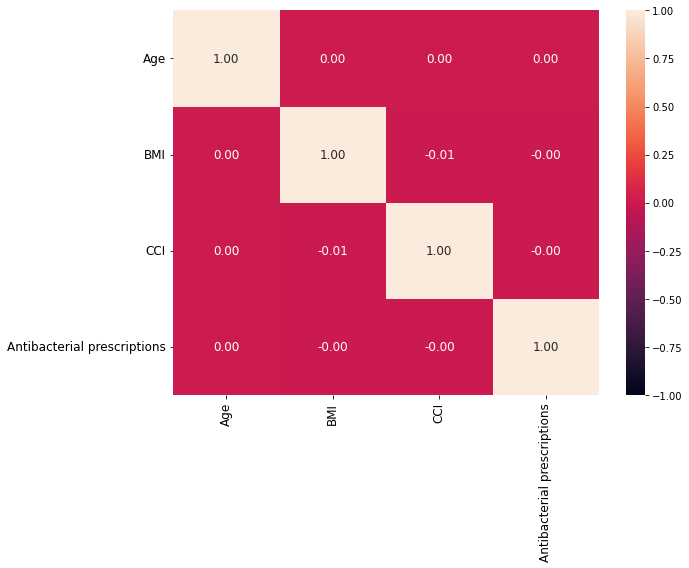

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

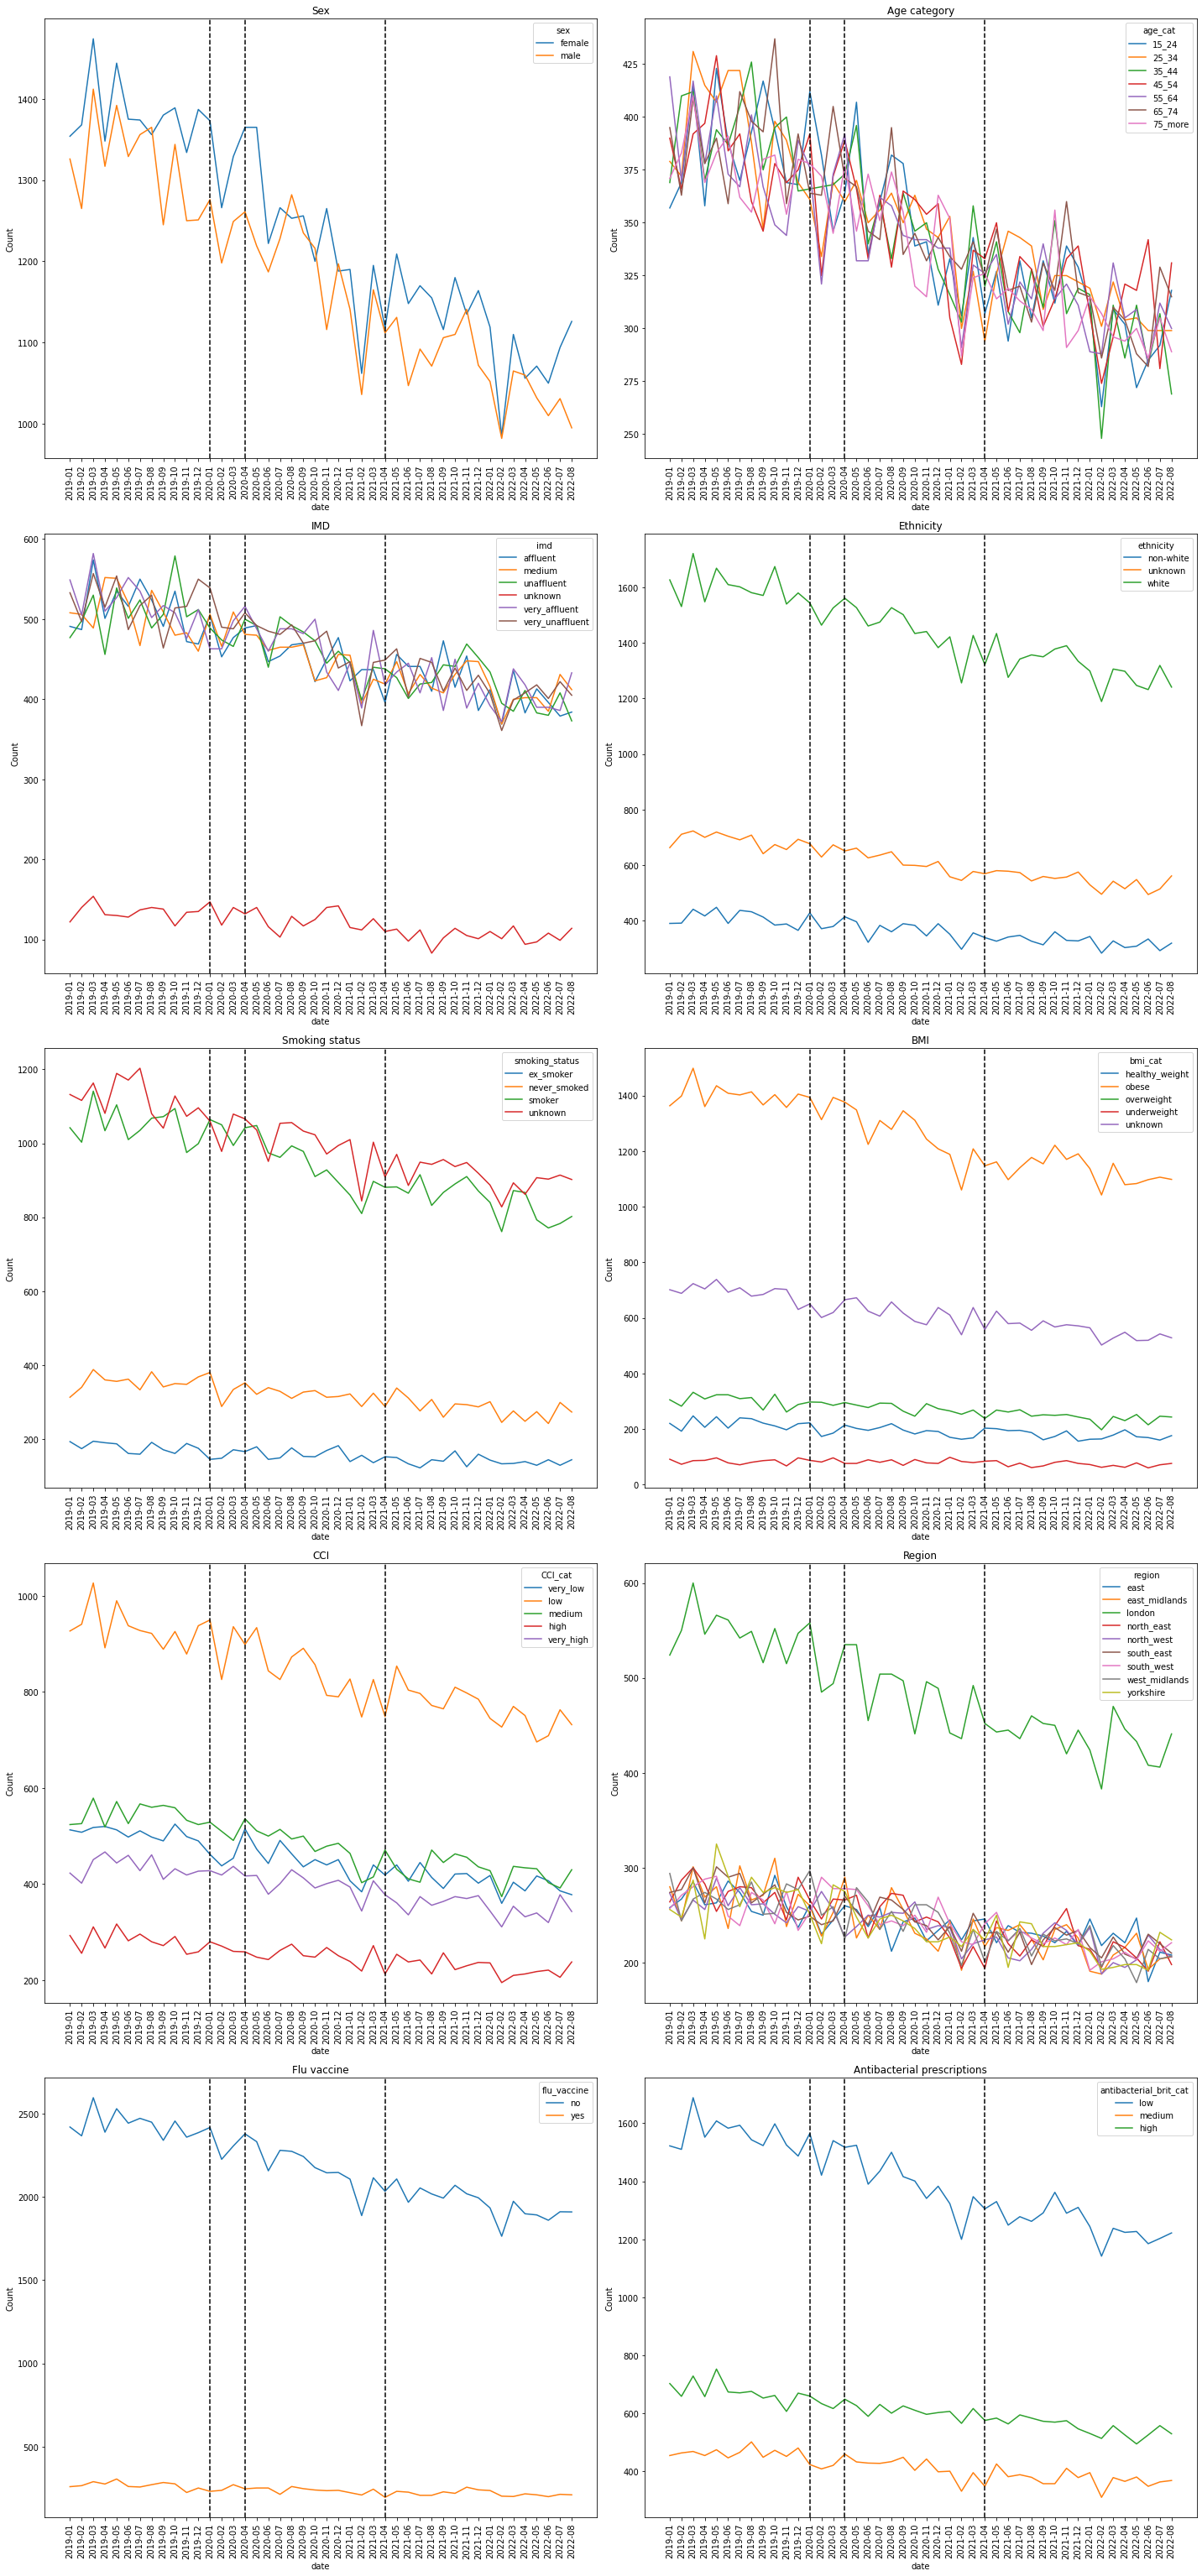

In [48]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_uti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_uti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_uti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_uti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_uti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_uti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_uti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_uti, 'region', 'Region', axes[3,1])
create_lineplot(data_uti, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_uti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of uti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/risk_factors_cat_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of uti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [49]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date',
                       'event_uti_admitted', 'duration_uti_admitted'
                        ]]

data_uti.shape

(106351, 17)

In [50]:
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]
#switch variable uti_ab_date into a binary variable
data_uti_incdt[['uti_ab_date']] = data_uti_incdt[['uti_ab_date']].where(data_uti_incdt[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_uti_prevl[['uti_ab_date']] = data_uti_prevl[['uti_ab_date']].where(data_uti_prevl[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_uti_incdt_males = data_uti_incdt[data_uti_incdt['sex'] == 'male']
data_uti_incdt_females = data_uti_incdt[data_uti_incdt['sex'] == 'female']
data_uti_prevl_males = data_uti_prevl[data_uti_prevl['sex'] == 'male']
data_uti_prevl_females = data_uti_prevl[data_uti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_uti_incdt_15_24 = data_uti_incdt[data_uti_incdt['age_cat'] == '15_24']
data_uti_incdt_25_34 = data_uti_incdt[data_uti_incdt['age_cat'] == '25_34']
data_uti_incdt_35_44 = data_uti_incdt[data_uti_incdt['age_cat'] == '35_44']
data_uti_incdt_45_54 = data_uti_incdt[data_uti_incdt['age_cat'] == '45_54']
data_uti_incdt_55_64 = data_uti_incdt[data_uti_incdt['age_cat'] == '55_64']
data_uti_incdt_65_74 = data_uti_incdt[data_uti_incdt['age_cat'] == '65_74']
data_uti_incdt_75_more = data_uti_incdt[data_uti_incdt['age_cat'] == '75_more']
data_uti_prevl_15_24 = data_uti_prevl[data_uti_prevl['age_cat'] == '15_24']
data_uti_prevl_25_34 = data_uti_prevl[data_uti_prevl['age_cat'] == '25_34']
data_uti_prevl_35_44 = data_uti_prevl[data_uti_prevl['age_cat'] == '35_44']
data_uti_prevl_45_54 = data_uti_prevl[data_uti_prevl['age_cat'] == '45_54']
data_uti_prevl_55_64 = data_uti_prevl[data_uti_prevl['age_cat'] == '55_64']
data_uti_prevl_65_74 = data_uti_prevl[data_uti_prevl['age_cat'] == '65_74']
data_uti_prevl_75_more = data_uti_prevl[data_uti_prevl['age_cat'] == '75_more']

data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['date'] <= '2019-12']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['date'] >= '2020-03') & (data_uti_incdt['date']<= '2021-03')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['date'] <= '2021-04']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['date'] <= '2019-12']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['date'] >= '2020-03') & (data_uti_prevl['date']<= '2021-03')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_uti_incdt_abtype_0 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[0]]
# data_uti_incdt_abtype_1 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[1]]
# data_uti_incdt_abtype_2 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[2]]
# data_uti_incdt_abtype_3 = data_uti_incdt[data_uti_incdt['ab_type_cat'] == data_uti['ab_type_cat'].unique()[3]]
# data_uti_prevl_abtype_0 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[0]]
# data_uti_prevl_abtype_1 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[1]]
# data_uti_prevl_abtype_2 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[2]]
# data_uti_prevl_abtype_3 = data_uti_prevl[data_uti_prevl['ab_type_cat'] == data_uti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_uti_incdt_abs = data_uti_incdt[data_uti_incdt['uti_ab_date'] == 1]
# data_uti_prevl_abs = data_uti_prevl[data_uti_prevl['uti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['uti_ab_date'].isnull()] #gp_cons_uti_ab
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['uti_ab_date'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['uti_ab_date'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

print(f'shape of data_uti_incdt: {data_uti_incdt.shape}')
print(f'shape of data_uti_prevl: {data_uti_prevl.shape}')
print(f'shape of data_uti_no_abs_incdt: {data_uti_no_abs_incdt.shape}')
print(f'shape of data_uti_abs_incdt: {data_uti_abs_incdt.shape}')
print(f'shape of data_uti_no_abs_prevl: {data_uti_no_abs_prevl.shape}')
print(f'shape of data_uti_abs_prevl: {data_uti_abs_prevl.shape}')
print(f'\nvalue counts of data_uti_no_abs_incdt: \n{data_uti_no_abs_incdt.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_abs_incdt: \n{data_uti_abs_incdt.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_no_abs_prevl: \n{data_uti_no_abs_prevl.event_uti_admitted.value_counts()}')
print(f'value counts of data_uti_abs_prevl: \n{data_uti_abs_prevl.event_uti_admitted.value_counts()}')

shape of data_uti_incdt: (95756, 17)
shape of data_uti_prevl: (10595, 17)
shape of data_uti_no_abs_incdt: (86106, 17)
shape of data_uti_abs_incdt: (9650, 17)
shape of data_uti_no_abs_prevl: (9503, 17)
shape of data_uti_abs_prevl: (1092, 17)

value counts of data_uti_no_abs_incdt: 
0.0    85465
1.0      641
Name: event_uti_admitted, dtype: int64
value counts of data_uti_abs_incdt: 
0.0    9579
1.0      71
Name: event_uti_admitted, dtype: int64
value counts of data_uti_no_abs_prevl: 
0.0    9439
1.0      64
Name: event_uti_admitted, dtype: int64
value counts of data_uti_abs_prevl: 
0.0    1085
1.0       7
Name: event_uti_admitted, dtype: int64


In [51]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 64579 total observations, 64096 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 64579
number of events observed = 483
   partial log-likelihood = -5332.95
         time fit was run = 2022-11-17 10:46:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.20       1.22       0.14            -0.07             0.47                 0.93                 1.60
CCI_cat[T.medium]                0.14       1.15       0.15            -0.16             0.45                 0.85                 1.56
CCI_cat[T.high]                  0.28       1.32       0.18            -0.07             0.63                 0.94                 1.87
CCI_cat[T.very_high]             0.27       1.31       0.16            -0.04             0.58                 0.96                 1.78
age_cat[T.25_34]                -0.10       0.90       0.17            -0.43             0.22                 0.65                 1.25
age_cat[T.35_44]                -0.19       0.83       0.17            -0.53             0.14                 0.59                 1.15
age_cat[T.45_54]                -0.22       0.80       0.17            -0.55             0.12                 0.57                 1.13
age_cat[T.55_64]                 0.06       1.06       0.16            -0.25             0.38                 0.78                 1.46
age_cat[T.65_74]                -0.18       0.84       0.17            -0.51             0.15                 0.60                 1.17
age_cat[T.75_more]              -0.04       0.96       0.16            -0.37             0.28                 0.69                 1.32
antibacterial_brit              -0.00       1.00       0.03            -0.07             0.06                 0.94                 1.06
bmi_cat[T.obese]                 0.20       1.22       0.18            -0.16             0.56                 0.85                 1.75
bmi_cat[T.overweight]            0.19       1.21       0.22            -0.23             0.62                 0.79                 1.85
bmi_cat[T.underweight]          -0.06       0.94       0.33            -0.70             0.58                 0.50                 1.78
bmi_cat[T.unknown]               0.10       1.11       0.20            -0.28             0.48                 0.75                 1.62
ethnicity[T.unknown]             0.06       1.06       0.15            -0.24             0.36                 0.79                 1.43
ethnicity[T.white]               0.10       1.10       0.13            -0.16             0.36                 0.85                 1.44
flu_vaccine[T.yes]              -0.26       0.77       0.17            -0.59             0.07                 0.56                 1.08
imd[T.medium]                    0.02       1.02       0.15            -0.26             0.31                 0.77                 1.36
imd[T.unaffluent]               -0.09       0.91       0.15            -0.38             0.20                 0.68                 1.22
imd[T.unknown]                   0.04       1.04       0.22            -0.40             0.47                 0.67                 1.60
imd[T.very_affluent]             0.01       1.01       0.14            -0.27             0.29                 0.76                 1.34
imd[T.very_unaffluent]          -0.15       0.86       0.15            -0.44             0.15                 0.64                 1.16
region[T.east_midlands]          0.38       1.47       0.22            -0.04             0.81                 0.96                 2.25
region[T.london]                 0.39       1.48       0.19           

12751


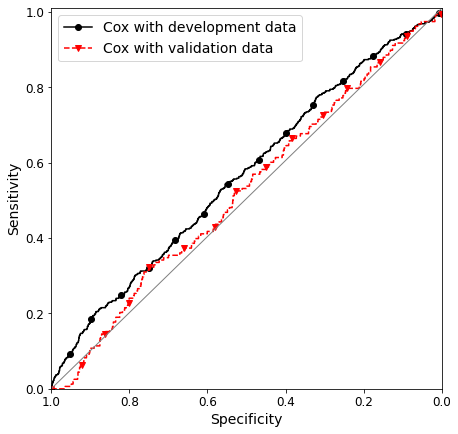

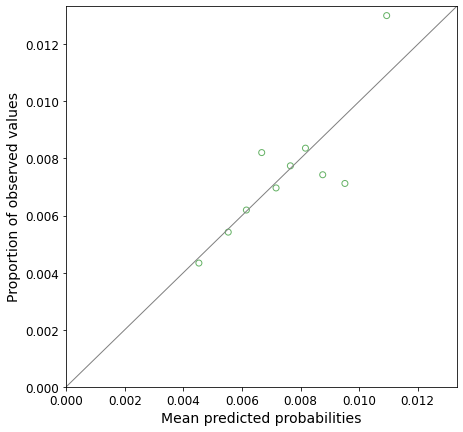

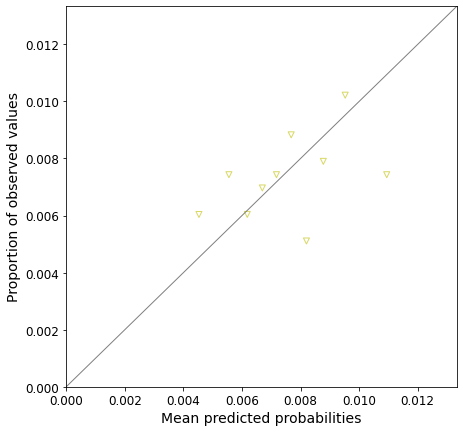

In [52]:
#data prep
data, data_uti_no_abs_incdt_enc = cox_data_prep(data_uti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_incdt', data_uti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_incdt', data_uti_no_abs_incdt)

try:
    #build cox model 
    cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test = cox_model_build('uti', 'no_abs_incdt', data_uti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_no_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_incdt.csv', data_uti_no_abs_incdt_enc, data_uti_no_abs_incdt, 'sum_betas_cph_uti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_no_abs_incdt, 'event_uti_admitted', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_no_abs_incdt, data_uti_no_abs_incdt_train, 'event_uti_admitted', data_uti_no_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_incdt_train.jpg', 'calibration_cph_uti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_no_abs_incdt, 'uti', 'no_abs_incdt', data_uti_no_abs_incdt_train, data_uti_no_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident uti with antibiotics

<lifelines.CoxPHFitter: fitted with 7237 total observations, 7181 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 7237
number of events observed = 56
   partial log-likelihood = -480.10
         time fit was run = 2022-11-17 10:46:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.39            -0.73             0.79                 0.48                 2.21
CCI_cat[T.medium]                0.16       1.18       0.43            -0.68             1.01                 0.51                 2.73
CCI_cat[T.high]                 -0.67       0.51       0.66            -1.96             0.62                 0.14                 1.87
CCI_cat[T.very_high]             0.18       1.20       0.44            -0.68             1.04                 0.51                 2.84
age_cat[T.25_34]                -0.03       0.97       0.63            -1.27             1.21                 0.28                 3.36
age_cat[T.35_44]                 0.43       1.54       0.57            -0.69             1.55                 0.50                 4.71
age_cat[T.45_54]                 0.82       2.27       0.53            -0.22             1.87                 0.80                 6.46
age_cat[T.55_64]                 0.56       1.74       0.56            -0.54             1.65                 0.58                 5.22
age_cat[T.65_74]                -0.26       0.77       0.67            -1.58             1.05                 0.21                 2.86
age_cat[T.75_more]               0.98       2.67       0.53            -0.05             2.02                 0.95                 7.51
antibacterial_brit               0.05       1.05       0.09            -0.13             0.23                 0.88                 1.26
bmi_cat[T.obese]                 0.88       2.40       0.73            -0.56             2.31                 0.57                10.09
bmi_cat[T.overweight]            0.05       1.05       0.91            -1.74             1.84                 0.18                 6.31
bmi_cat[T.underweight]           0.94       2.55       1.00            -1.03             2.90                 0.36                18.19
bmi_cat[T.unknown]               1.08       2.94       0.75            -0.38             2.54                 0.68                12.67
ethnicity[T.unknown]             1.08       2.94       0.64            -0.17             2.33                 0.84                10.26
ethnicity[T.white]               1.23       3.41       0.60             0.05             2.40                 1.05                11.04
flu_vaccine[T.yes]              -0.27       0.76       0.52            -1.29             0.75                 0.28                 2.12
imd[T.medium]                    0.29       1.33       0.44            -0.58             1.16                 0.56                 3.18
imd[T.unaffluent]                0.47       1.60       0.42            -0.36             1.30                 0.70                 3.67
imd[T.unknown]                   0.02       1.02       0.78            -1.52             1.56                 0.22                 4.74
imd[T.very_affluent]             0.13       1.14       0.46            -0.77             1.04                 0.46                 2.82
imd[T.very_unaffluent]          -0.12       0.89       0.49            -1.08             0.84                 0.34                 2.31
region[T.east_midlands]         -0.33       0.72       0.77            -1.83             1.17                 0.16                 3.24
region[T.london]                 0.62       1.87       0.56            -0.4

12749


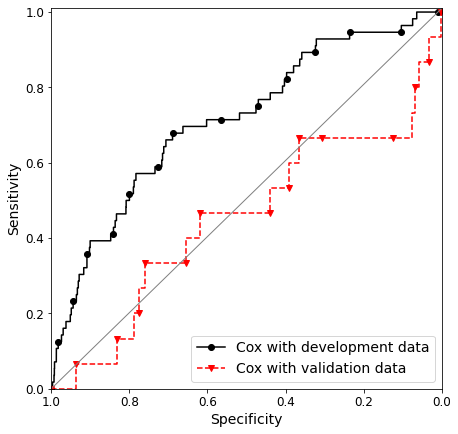

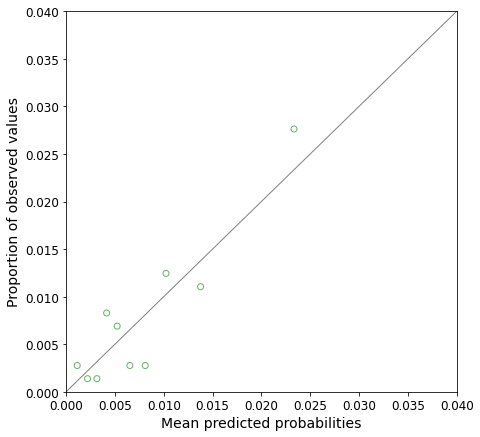

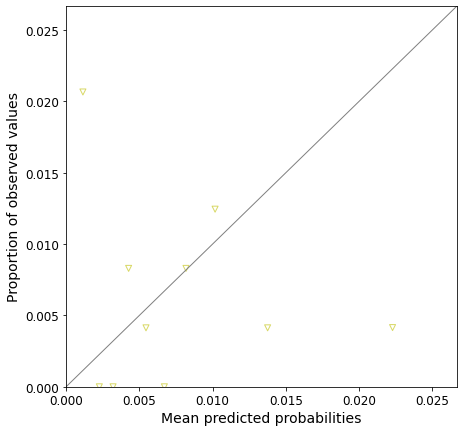

In [53]:
#data prep
data, data_uti_abs_incdt_enc = cox_data_prep(data_uti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_incdt', data_uti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_incdt', data_uti_abs_incdt)

try:
    #build cox model 
    cph_uti_abs_incdt, data_uti_abs_incdt_train, data_uti_abs_incdt_test = cox_model_build('uti', 'abs_incdt', data_uti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_abs_incdt, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_incdt.csv', data_uti_abs_incdt_enc, data_uti_abs_incdt, 'sum_betas_cph_uti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_abs_incdt, 'event_uti_admitted', data_uti_abs_incdt_train, data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_abs_incdt, data_uti_abs_incdt_train, 'event_uti_admitted', data_uti_abs_incdt_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_incdt_train.jpg', 'calibration_cph_uti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_abs_incdt, 'uti', 'abs_incdt', data_uti_abs_incdt_train, data_uti_abs_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent uti with no antibiotics

<lifelines.CoxPHFitter: fitted with 7127 total observations, 7077 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 7127
number of events observed = 50
   partial log-likelihood = -418.44
         time fit was run = 2022-11-17 10:46:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.42            -1.11             0.52                 0.33                 1.68
CCI_cat[T.medium]               -0.20       0.82       0.46            -1.11             0.70                 0.33                 2.02
CCI_cat[T.high]                  0.17       1.18       0.50            -0.80             1.14                 0.45                 3.12
CCI_cat[T.very_high]             0.22       1.25       0.45            -0.66             1.11                 0.52                 3.02
age_cat[T.25_34]                 1.01       2.73       0.68            -0.33             2.34                 0.72                10.34
age_cat[T.35_44]                 0.64       1.89       0.71            -0.75             2.03                 0.47                 7.59
age_cat[T.45_54]                 0.78       2.18       0.71            -0.61             2.17                 0.54                 8.77
age_cat[T.55_64]                 1.04       2.83       0.67            -0.27             2.35                 0.76                10.49
age_cat[T.65_74]                 0.88       2.42       0.69            -0.47             2.24                 0.62                 9.38
age_cat[T.75_more]               1.36       3.91       0.65             0.08             2.64                 1.09                14.08
antibacterial_brit               0.06       1.07       0.10            -0.13             0.25                 0.88                 1.29
bmi_cat[T.obese]                -0.14       0.87       0.49            -1.09             0.82                 0.34                 2.26
bmi_cat[T.overweight]           -1.32       0.27       0.84            -2.96             0.33                 0.05                 1.38
bmi_cat[T.underweight]         -16.15       0.00    2190.90         -4310.24          4277.94                 0.00                  inf
bmi_cat[T.unknown]              -0.30       0.74       0.53            -1.34             0.73                 0.26                 2.08
ethnicity[T.unknown]            -0.05       0.95       0.45            -0.94             0.83                 0.39                 2.30
ethnicity[T.white]              -0.09       0.91       0.40            -0.88             0.69                 0.42                 2.00
flu_vaccine[T.yes]               0.45       1.57       0.41            -0.35             1.26                 0.70                 3.51
imd[T.medium]                    0.56       1.75       0.51            -0.44             1.56                 0.65                 4.74
imd[T.unaffluent]                1.14       3.14       0.47             0.22             2.07                 1.25                 7.89
imd[T.unknown]                   0.21       1.23       0.82            -1.40             1.82                 0.25                 6.15
imd[T.very_affluent]             0.13       1.14       0.56            -0.96             1.22                 0.38                 3.40
imd[T.very_unaffluent]          -0.23       0.79       0.61            -1.43             0.96                 0.24                 2.61
region[T.east_midlands]         -0.38       0.68       0.51            -1.38             0.61                 0.25                 1.84
region[T.london]                -0.78       0.46       0.49            -1.7

12773


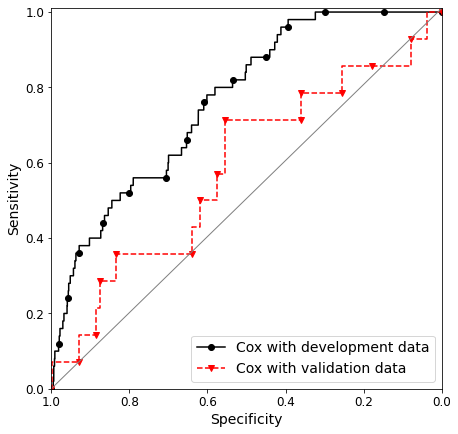

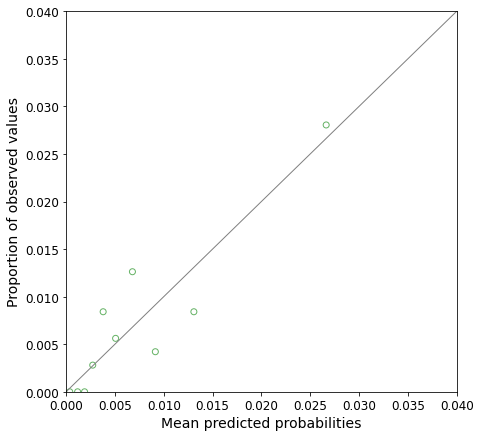

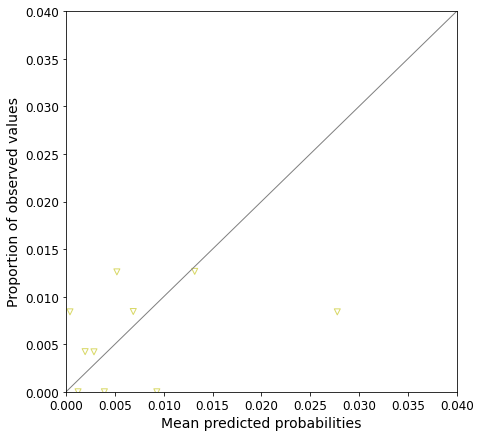

In [54]:
#data prep
data, data_uti_no_abs_prevl_enc = cox_data_prep(data_uti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'no_abs_prevl', data_uti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'no_abs_prevl', data_uti_no_abs_prevl)

try:
    #build cox model 
    cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test = cox_model_build('uti', 'no_abs_prevl', data_uti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_no_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_no_abs_prevl.csv', data_uti_no_abs_prevl_enc, data_uti_no_abs_prevl, 'sum_betas_cph_uti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_no_abs_prevl, 'event_uti_admitted', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_no_abs_prevl, data_uti_no_abs_prevl_train, 'event_uti_admitted', data_uti_no_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_no_abs_prevl_train.jpg', 'calibration_cph_uti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_no_abs_prevl, 'uti', 'no_abs_prevl', data_uti_no_abs_prevl_train, data_uti_no_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent uti with antibiotics

<lifelines.CoxPHFitter: fitted with 819 total observations, 815 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 819
number of events observed = 4
   partial log-likelihood = -6.95
         time fit was run = 2022-11-17 10:47:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   5.47     237.88       6.84            -7.93            18.88                 0.00             1.58e+08
CCI_cat[T.medium]                4.17      64.88       6.96            -9.47            17.81                 0.00             5.43e+07
CCI_cat[T.high]                 -6.91       0.00      10.47           -27.43            13.61                 0.00             8.13e+05
CCI_cat[T.very_high]            -2.04       0.13       9.61           -20.87            16.80                 0.00             1.97e+07
age_cat[T.25_34]                 2.37      10.71      11.08           -19.34            24.08                 0.00             2.88e+10
age_cat[T.35_44]                 9.12    9105.24       7.82            -6.21            24.44                 0.00             4.13e+10
age_cat[T.45_54]                 8.89    7261.53       8.91            -8.57            26.35                 0.00             2.78e+11
age_cat[T.55_64]                 1.13       3.11       9.89           -18.24            20.51                 0.00             8.07e+08
age_cat[T.65_74]                 1.26       3.52      10.83           -19.96            22.48                 0.00             5.80e+09
age_cat[T.75_more]              11.01   60388.36       8.45            -5.54            27.56                 0.00             9.33e+11
antibacterial_brit               0.67       1.96       1.00            -1.28             2.63                 0.28                13.92
bmi_cat[T.obese]                 7.60    1988.47       8.85            -9.75            24.94                 0.00             6.81e+10
bmi_cat[T.overweight]            4.52      91.45      12.67           -20.31            29.34                 0.00             5.55e+12
bmi_cat[T.underweight]           3.14      23.22      19.29           -34.66            40.95                 0.00             6.10e+17
bmi_cat[T.unknown]               4.10      60.55       9.50           -14.52            22.73                 0.00             7.41e+09
ethnicity[T.unknown]             0.45       1.56       4.08            -7.55             8.44                 0.00              4620.34
ethnicity[T.white]              -1.96       0.14       3.79            -9.38             5.47                 0.00               237.69
flu_vaccine[T.yes]               2.63      13.85       3.16            -3.57             8.83                 0.03              6803.51
imd[T.medium]                    6.07     432.30       4.79            -3.33            15.47                 0.04             5.22e+06
imd[T.unaffluent]               -7.88       0.00      10.12           -27.72            11.96                 0.00             1.56e+05
imd[T.unknown]                  -2.90       0.06      12.91           -28.19            22.40                 0.00             5.32e+09
imd[T.very_affluent]            -5.95       0.00       7.01           -19.70             7.79                 0.00              2421.43
imd[T.very_unaffluent]          -1.18       0.31       3.44            -7.92             5.57                 0.00               262.27
region[T.east_midlands]          7.76    2335.18       8.93            -9.74            25.25                 0.00             9.27e+10
region[T.london]                 2.04       7.67       9.01           -15.62     

12989


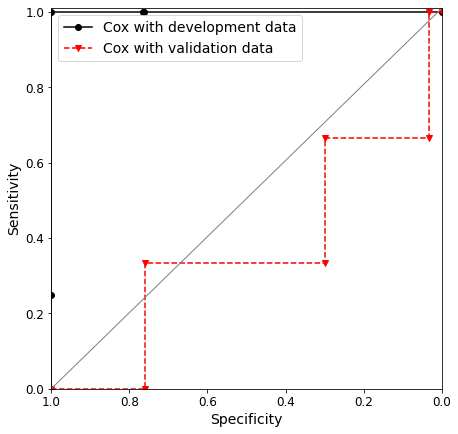

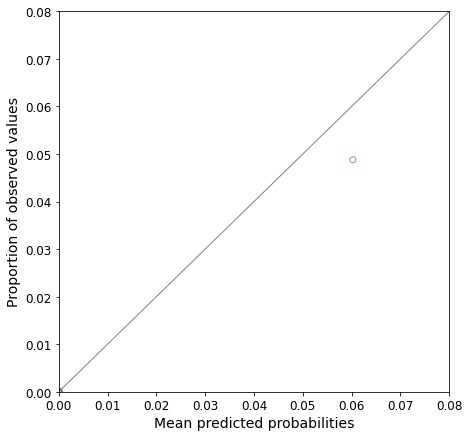

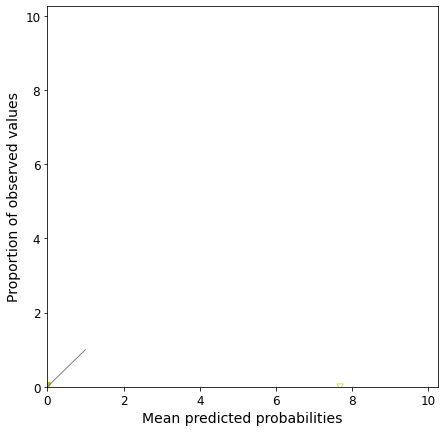

In [55]:
#data prep
data, data_uti_abs_prevl_enc = cox_data_prep(data_uti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'abs_prevl', data_uti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('uti', 'abs_prevl', data_uti_abs_prevl)

try:
    #build cox model 
    cph_uti_abs_prevl, data_uti_abs_prevl_train, data_uti_abs_prevl_test = cox_model_build('uti', 'abs_prevl', data_uti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_uti_abs_prevl, '../output/hospitalisation_prediction_uti/', 'betas_cph_uti_abs_prevl.csv', data_uti_abs_prevl_enc, data_uti_abs_prevl, 'sum_betas_cph_uti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_uti_abs_prevl, 'event_uti_admitted', data_uti_abs_prevl_train, data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti', 'roc_cph_uti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_uti_abs_prevl, data_uti_abs_prevl_train, 'event_uti_admitted', data_uti_abs_prevl_test, '../output/hospitalisation_prediction_uti/', 'calibration_cph_uti_abs_prevl_train.jpg', 'calibration_cph_uti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_uti_abs_prevl, 'uti', 'abs_prevl', data_uti_abs_prevl_train, data_uti_abs_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident uti

In [56]:
#data prep
data, data_uti_incdt_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'incdt', data_uti_incdt_enc)
make_summary_table_hosped('uti', 'incdt', data_uti_incdt)

try:
    cph_uti_incdt, data_uti_incdt_train, data_uti_incdt_test = cox_model_abs_build('uti', 'incdt', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt, 'uti', 'incdt', data_uti_incdt_train, data_uti_incdt_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71817 total observations, 71274 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 71817
number of events observed = 543
   partial log-likelihood = -6056.72
         time fit was run = 2022-11-17 10:47:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.23       0.13            -0.05             0.46                 0.96                 1.58
CCI_cat[T.medium]                0.10       1.11       0.15            -0.18             0.39                 0.83                 1.47
CCI_cat[T.high]                  0.11       1.12       0.17            -0.23             0.45                 0.80                 1.57
CCI_cat[T.very_high]             0.25       1.28       0.15            -0.04             0.54                 0.96                 1.71
age_cat[T.25_34]                -0.11       0.90       0.16            -0.43             0.22                 0.65                 1.24
age_cat[T.35_44]                -0.01       0.99       0.16            -0.32             0.31                 0.72                 1.36
age_cat[T.45_54]                -0.10       0.91       0.17            -0.42             0.23                 0.66                 1.25
age_cat[T.55_64]                 0.16       1.17       0.16            -0.15             0.46                 0.86                 1.59
age_cat[T.65_74]                -0.07       0.93       0.16            -0.40             0.25                 0.67                 1.28
age_cat[T.75_more]               0.14       1.15       0.16            -0.16             0.45                 0.85                 1.57
antibacterial_brit               0.02       1.02       0.03            -0.04             0.07                 0.96                 1.08
bmi_cat[T.obese]                 0.18       1.20       0.17            -0.15             0.52                 0.86                 1.69
bmi_cat[T.overweight]            0.11       1.11       0.21            -0.30             0.51                 0.74                 1.67
bmi_cat[T.underweight]          -0.03       0.97       0.30            -0.63             0.57                 0.53                 1.76
bmi_cat[T.unknown]               0.15       1.16       0.18            -0.21             0.51                 0.81                 1.66
ethnicity[T.unknown]             0.16       1.18       0.15            -0.13             0.45                 0.88                 1.58
ethnicity[T.white]               0.21       1.24       0.13            -0.05             0.47                 0.96                 1.60
flu_vaccine[T.yes]              -0.29       0.74       0.16            -0.61             0.02                 0.54                 1.02
imd[T.medium]                    0.01       1.01       0.14            -0.27             0.28                 0.77                 1.32
imd[T.unaffluent]               -0.01       0.99       0.14            -0.29             0.26                 0.75                 1.30
imd[T.unknown]                   0.08       1.09       0.21            -0.33             0.50                 0.72                 1.64
imd[T.very_affluent]             0.06       1.06       0.14            -0.21             0.33                 0.81                 1.38
imd[T.very_unaffluent]          -0.07       0.93       0.14            -0.35             0.21                 0.71                 1.23
region[T.east_midlands]          0.12       1.13       0.19            -0.26             0.50                 0.77                 1.64
region[T.london]                 0.18       1.20       0.17           

13030


### 5-6- hospital admission related to prevalent uti

In [57]:
#data prep
data, data_uti_prevl_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary tables from preped data
make_summary_table('uti', 'prevl', data_uti_prevl_enc)
make_summary_table_hosped('uti', 'prevl', data_uti_prevl)

try:
    cph_uti_prevl, data_uti_prevl_train, data_uti_prevl_test = cox_model_abs_build('uti', 'prevl', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl, 'uti', 'prevl', data_uti_prevl_train, data_uti_prevl_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7946 total observations, 7894 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 7946
number of events observed = 52
   partial log-likelihood = -446.69
         time fit was run = 2022-11-17 10:47:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.45            -1.32             0.45                 0.27                 1.57
CCI_cat[T.medium]                0.30       1.35       0.44            -0.55             1.15                 0.58                 3.17
CCI_cat[T.high]                  0.25       1.28       0.51            -0.74             1.24                 0.48                 3.46
CCI_cat[T.very_high]             0.46       1.59       0.44            -0.41             1.33                 0.67                 3.78
age_cat[T.25_34]                 0.95       2.58       0.60            -0.23             2.13                 0.79                 8.43
age_cat[T.35_44]                 0.62       1.85       0.63            -0.62             1.85                 0.54                 6.34
age_cat[T.45_54]                 0.52       1.68       0.65            -0.75             1.78                 0.47                 5.96
age_cat[T.55_64]                 0.69       1.99       0.61            -0.52             1.89                 0.60                 6.63
age_cat[T.65_74]                 0.45       1.57       0.65            -0.82             1.72                 0.44                 5.57
age_cat[T.75_more]               1.22       3.40       0.58             0.09             2.36                 1.09                10.57
antibacterial_brit               0.05       1.06       0.10            -0.13             0.24                 0.88                 1.27
bmi_cat[T.obese]                 0.03       1.03       0.54            -1.02             1.08                 0.36                 2.93
bmi_cat[T.overweight]           -0.45       0.64       0.71            -1.84             0.94                 0.16                 2.57
bmi_cat[T.underweight]         -15.88       0.00    2154.65         -4238.93          4207.16                 0.00                  inf
bmi_cat[T.unknown]               0.06       1.06       0.57            -1.05             1.17                 0.35                 3.22
ethnicity[T.unknown]             0.08       1.09       0.47            -0.84             1.00                 0.43                 2.73
ethnicity[T.white]               0.12       1.13       0.42            -0.70             0.94                 0.50                 2.57
flu_vaccine[T.yes]               0.47       1.60       0.39            -0.29             1.23                 0.75                 3.43
imd[T.medium]                    0.40       1.50       0.46            -0.49             1.30                 0.61                 3.67
imd[T.unaffluent]                0.61       1.83       0.44            -0.27             1.48                 0.77                 4.38
imd[T.unknown]                   0.02       1.02       0.79            -1.53             1.58                 0.22                 4.84
imd[T.very_affluent]             0.14       1.15       0.49            -0.82             1.09                 0.44                 2.99
imd[T.very_unaffluent]          -0.08       0.92       0.52            -1.10             0.94                 0.33                 2.55
region[T.east_midlands]         -0.33       0.72       0.51            -1.32             0.66                 0.27                 1.94
region[T.london]                -1.08       0.34       0.53            -2.1

13027


### 5-7- hospital admission related to incident uti with prescribed antibiotics categories

In [58]:
#data prep
data, data_uti_incdt_abs_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_abs, data_uti_incdt_abs_train, data_uti_incdt_abs_test = cox_model_ab_type_build('uti', 'incdt_ab_type', data_uti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_abs, 'uti', 'incdt_abs', data_uti_incdt_abs_train, data_uti_incdt_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71817 total observations, 71274 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 71817
number of events observed = 543
   partial log-likelihood = -6056.15
         time fit was run = 2022-11-17 10:47:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.23       0.13            -0.05             0.46                 0.96                 1.58
CCI_cat[T.medium]                0.10       1.11       0.15            -0.18             0.39                 0.83                 1.47
CCI_cat[T.high]                  0.11       1.12       0.17            -0.23             0.45                 0.80                 1.57
CCI_cat[T.very_high]             0.25       1.28       0.15            -0.04             0.54                 0.96                 1.71
ab_type_cat[T.Doxycycline]       1.09       2.98       1.00            -0.87             3.05                 0.42                21.15
ab_type_cat[T.no]                0.44       1.55       0.71            -0.95             1.83                 0.39                 6.22
ab_type_cat[T.other]             0.44       1.55       0.72            -0.97             1.85                 0.38                 6.38
age_cat[T.25_34]                -0.11       0.90       0.16            -0.43             0.22                 0.65                 1.24
age_cat[T.35_44]                -0.01       0.99       0.16            -0.33             0.31                 0.72                 1.36
age_cat[T.45_54]                -0.10       0.91       0.17            -0.42             0.23                 0.66                 1.25
age_cat[T.55_64]                 0.16       1.17       0.16            -0.15             0.46                 0.86                 1.59
age_cat[T.65_74]                -0.07       0.93       0.16            -0.40             0.25                 0.67                 1.28
age_cat[T.75_more]               0.14       1.15       0.16            -0.16             0.45                 0.85                 1.57
antibacterial_brit               0.02       1.02       0.03            -0.04             0.07                 0.96                 1.08
bmi_cat[T.obese]                 0.19       1.20       0.17            -0.15             0.52                 0.86                 1.69
bmi_cat[T.overweight]            0.11       1.11       0.21            -0.30             0.51                 0.74                 1.67
bmi_cat[T.underweight]          -0.03       0.97       0.31            -0.63             0.57                 0.53                 1.76
bmi_cat[T.unknown]               0.15       1.16       0.18            -0.21             0.51                 0.81                 1.66
ethnicity[T.unknown]             0.16       1.18       0.15            -0.13             0.45                 0.88                 1.58
ethnicity[T.white]               0.21       1.24       0.13            -0.05             0.47                 0.96                 1.60
flu_vaccine[T.yes]              -0.29       0.75       0.16            -0.61             0.02                 0.54                 1.02
imd[T.medium]                    0.01       1.01       0.14            -0.27             0.28                 0.76                 1.32
imd[T.unaffluent]               -0.01       0.99       0.14            -0.29             0.26                 0.75                 1.30
imd[T.unknown]                   0.08       1.09       0.21            -0.33             0.50                 0.72                 1.64
imd[T.very_affluent]             0.06       1.06       0.14           

13593


### 5-8- hospital admission related to prevalent uti with prescribed antibiotics categories

In [59]:
#data prep
data, data_uti_prevl_abs_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_abs, data_uti_prevl_abs_train, data_uti_prevl_abs_test = cox_model_ab_type_build('uti', 'prevl_ab_type', data_uti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_abs, 'uti', 'prevl_abs', data_uti_prevl_abs_train, data_uti_prevl_abs_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7946 total observations, 7894 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 7946
number of events observed = 52
   partial log-likelihood = -445.05
         time fit was run = 2022-11-17 10:47:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.45            -1.32             0.45                 0.27                 1.57
CCI_cat[T.medium]                0.30       1.35       0.44            -0.55             1.16                 0.58                 3.18
CCI_cat[T.high]                  0.21       1.23       0.51            -0.79             1.21                 0.45                 3.35
CCI_cat[T.very_high]             0.46       1.58       0.44            -0.41             1.33                 0.66                 3.77
ab_type_cat[T.Doxycycline]      17.27   3.15e+07    4524.34         -8850.27          8884.80                 0.00                  inf
ab_type_cat[T.no]               15.67   6.38e+06    4524.34         -8851.87          8883.20                 0.00                  inf
ab_type_cat[T.other]            14.65   2.30e+06    4524.34         -8852.89          8882.18                 0.00                  inf
age_cat[T.25_34]                 0.96       2.61       0.60            -0.22             2.14                 0.80                 8.54
age_cat[T.35_44]                 0.64       1.89       0.63            -0.60             1.87                 0.55                 6.49
age_cat[T.45_54]                 0.54       1.72       0.65            -0.73             1.81                 0.48                 6.13
age_cat[T.55_64]                 0.70       2.01       0.61            -0.51             1.90                 0.60                 6.71
age_cat[T.65_74]                 0.46       1.59       0.65            -0.81             1.73                 0.45                 5.66
age_cat[T.75_more]               1.23       3.44       0.58             0.10             2.37                 1.10                10.70
antibacterial_brit               0.05       1.05       0.10            -0.14             0.24                 0.87                 1.27
bmi_cat[T.obese]                 0.02       1.02       0.54            -1.03             1.07                 0.36                 2.90
bmi_cat[T.overweight]           -0.44       0.65       0.71            -1.83             0.95                 0.16                 2.59
bmi_cat[T.underweight]         -15.62       0.00    1906.24         -3751.78          3720.54                 0.00                  inf
bmi_cat[T.unknown]               0.04       1.05       0.57            -1.06             1.15                 0.34                 3.17
ethnicity[T.unknown]             0.08       1.09       0.47            -0.84             1.00                 0.43                 2.73
ethnicity[T.white]               0.12       1.12       0.42            -0.71             0.94                 0.49                 2.56
flu_vaccine[T.yes]               0.48       1.62       0.39            -0.28             1.24                 0.76                 3.46
imd[T.medium]                    0.41       1.50       0.46            -0.49             1.31                 0.61                 3.69
imd[T.unaffluent]                0.62       1.86       0.44            -0.25             1.49                 0.78                 4.46
imd[T.unknown]                  -0.03       0.97       0.80            -1.59             1.53                 0.20                 4.63
imd[T.very_affluent]             0.13       1.14       0.49            -0.8

13632


### 5-9- stratified by sex
#### 5-9-1- incident males

In [60]:
#data prep
data, data_uti_incdt_males_enc = cox_data_prep(data_uti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_males, data_uti_incdt_males_train, data_uti_incdt_males_test = cox_model_strat_sex_build('uti', 'incdt_males', data_uti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_males, 'uti', 'incdt_males', data_uti_incdt_males_train, data_uti_incdt_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35131 total observations, 34868 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 35131
number of events observed = 263
   partial log-likelihood = -2722.97
         time fit was run = 2022-11-17 10:47:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.51       1.67       0.20             0.13             0.90                 1.14                 2.45
CCI_cat[T.medium]                0.17       1.19       0.23            -0.28             0.62                 0.76                 1.87
CCI_cat[T.high]                  0.52       1.68       0.25             0.03             1.01                 1.03                 2.75
CCI_cat[T.very_high]             0.48       1.62       0.22             0.04             0.92                 1.04                 2.51
age_cat[T.25_34]                -0.43       0.65       0.23            -0.87             0.02                 0.42                 1.02
age_cat[T.35_44]                -0.29       0.75       0.22            -0.72             0.13                 0.49                 1.14
age_cat[T.45_54]                -0.35       0.70       0.22            -0.79             0.08                 0.46                 1.09
age_cat[T.55_64]                -0.10       0.91       0.21            -0.50             0.31                 0.60                 1.36
age_cat[T.65_74]                -0.38       0.69       0.23            -0.82             0.06                 0.44                 1.07
age_cat[T.75_more]              -0.38       0.69       0.23            -0.82             0.06                 0.44                 1.07
antibacterial_brit              -0.02       0.98       0.04            -0.10             0.07                 0.90                 1.07
bmi_cat[T.obese]                 0.21       1.23       0.26            -0.30             0.71                 0.74                 2.04
bmi_cat[T.overweight]            0.43       1.53       0.29            -0.15             1.00                 0.86                 2.73
bmi_cat[T.underweight]          -0.12       0.89       0.48            -1.05             0.81                 0.35                 2.26
bmi_cat[T.unknown]               0.25       1.29       0.27            -0.28             0.78                 0.76                 2.19
ethnicity[T.unknown]             0.66       1.94       0.24             0.19             1.14                 1.21                 3.13
ethnicity[T.white]               0.68       1.97       0.23             0.23             1.12                 1.26                 3.07
flu_vaccine[T.yes]              -0.56       0.57       0.26            -1.07            -0.06                 0.34                 0.94
imd[T.medium]                    0.10       1.11       0.21            -0.32             0.52                 0.73                 1.68
imd[T.unaffluent]                0.19       1.21       0.21            -0.21             0.60                 0.81                 1.81
imd[T.unknown]                   0.54       1.72       0.28             0.00             1.08                 1.00                 2.95
imd[T.very_affluent]             0.19       1.21       0.21            -0.21             0.60                 0.81                 1.82
imd[T.very_unaffluent]           0.19       1.21       0.21            -0.22             0.59                 0.80                 1.81
region[T.east_midlands]         -0.39       0.68       0.27            -0.92             0.13                 0.40                 1.14
region[T.london]                -0.21       0.81       0.22           

12767


#### 5-9-2- incident females

In [61]:
#data prep
data, data_uti_incdt_females_enc = cox_data_prep(data_uti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_females, data_uti_incdt_females_train, data_uti_incdt_females_test = cox_model_strat_sex_build('uti', 'incdt_females', data_uti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_females, 'uti', 'incdt_females', data_uti_incdt_females_train, data_uti_incdt_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36685 total observations, 36407 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 36685
number of events observed = 278
   partial log-likelihood = -2901.00
         time fit was run = 2022-11-17 10:47:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.47       0.18             0.02             0.75                 1.02                 2.11
CCI_cat[T.medium]                0.18       1.20       0.21            -0.24             0.59                 0.79                 1.81
CCI_cat[T.high]                  0.32       1.38       0.24            -0.15             0.79                 0.86                 2.19
CCI_cat[T.very_high]             0.28       1.32       0.22            -0.14             0.70                 0.87                 2.02
age_cat[T.25_34]                 0.23       1.26       0.24            -0.24             0.71                 0.78                 2.03
age_cat[T.35_44]                 0.36       1.44       0.24            -0.10             0.83                 0.90                 2.29
age_cat[T.45_54]                 0.19       1.21       0.25            -0.29             0.68                 0.75                 1.97
age_cat[T.55_64]                 0.18       1.20       0.25            -0.30             0.67                 0.74                 1.95
age_cat[T.65_74]                 0.24       1.27       0.24            -0.24             0.71                 0.79                 2.04
age_cat[T.75_more]               0.58       1.79       0.23             0.13             1.03                 1.14                 2.79
antibacterial_brit               0.03       1.03       0.04            -0.05             0.11                 0.95                 1.12
bmi_cat[T.obese]                 0.28       1.33       0.25            -0.21             0.77                 0.81                 2.16
bmi_cat[T.overweight]            0.04       1.04       0.31            -0.56             0.64                 0.57                 1.90
bmi_cat[T.underweight]           0.38       1.46       0.38            -0.37             1.13                 0.69                 3.09
bmi_cat[T.unknown]               0.23       1.25       0.26            -0.29             0.74                 0.75                 2.11
ethnicity[T.unknown]             0.13       1.14       0.20            -0.26             0.51                 0.77                 1.67
ethnicity[T.white]               0.04       1.04       0.18            -0.31             0.39                 0.73                 1.47
flu_vaccine[T.yes]              -0.23       0.80       0.22            -0.66             0.21                 0.51                 1.23
imd[T.medium]                    0.08       1.08       0.19            -0.29             0.45                 0.74                 1.57
imd[T.unaffluent]               -0.12       0.89       0.20            -0.51             0.27                 0.60                 1.31
imd[T.unknown]                  -0.26       0.77       0.33            -0.91             0.39                 0.40                 1.47
imd[T.very_affluent]            -0.02       0.98       0.19            -0.40             0.36                 0.67                 1.43
imd[T.very_unaffluent]           0.02       1.02       0.19            -0.35             0.40                 0.70                 1.49
region[T.east_midlands]          0.37       1.45       0.28            -0.17             0.91                 0.84                 2.48
region[T.london]                 0.48       1.62       0.24           

12747


#### 5-9-3- prevalent males

In [62]:
#data prep
data, data_uti_prevl_males_enc = cox_data_prep(data_uti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_males, data_uti_prevl_males_train, data_uti_prevl_males_test = cox_model_strat_sex_build('uti', 'prevl_males', data_uti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_uti_prevl_males, 'uti', 'prevl_males', data_uti_prevl_males_train, data_uti_prevl_males_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3843 total observations, 3815 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3843
number of events observed = 28
   partial log-likelihood = -209.55
         time fit was run = 2022-11-17 10:47:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.47       0.62       0.61            -1.67             0.72                 0.19                 2.06
CCI_cat[T.medium]                0.09       1.09       0.61            -1.11             1.29                 0.33                 3.62
CCI_cat[T.high]                  0.03       1.03       0.74            -1.42             1.48                 0.24                 4.38
CCI_cat[T.very_high]             0.61       1.84       0.58            -0.53             1.74                 0.59                 5.72
age_cat[T.25_34]                 0.56       1.76       0.66            -0.72             1.85                 0.49                 6.34
age_cat[T.35_44]                -0.44       0.65       0.78            -1.96             1.08                 0.14                 2.96
age_cat[T.45_54]                -0.60       0.55       0.87            -2.31             1.10                 0.10                 3.02
age_cat[T.55_64]                -0.78       0.46       0.87            -2.48             0.93                 0.08                 2.54
age_cat[T.65_74]                -0.26       0.77       0.77            -1.77             1.25                 0.17                 3.48
age_cat[T.75_more]               0.64       1.90       0.62            -0.57             1.85                 0.56                 6.38
antibacterial_brit               0.10       1.10       0.14            -0.17             0.36                 0.85                 1.44
bmi_cat[T.obese]                 0.16       1.17       0.76            -1.33             1.64                 0.26                 5.16
bmi_cat[T.overweight]           -1.23       0.29       1.23            -3.65             1.18                 0.03                 3.24
bmi_cat[T.underweight]         -17.95       0.00    8711.41        -17092.00         17056.09                 0.00                  inf
bmi_cat[T.unknown]               0.27       1.31       0.79            -1.28             1.82                 0.28                 6.16
ethnicity[T.unknown]             0.11       1.11       0.64            -1.14             1.35                 0.32                 3.86
ethnicity[T.white]               0.11       1.12       0.56            -0.99             1.21                 0.37                 3.37
flu_vaccine[T.yes]               0.64       1.90       0.50            -0.35             1.63                 0.71                 5.08
imd[T.medium]                    0.65       1.91       0.62            -0.56             1.85                 0.57                 6.39
imd[T.unaffluent]                0.63       1.88       0.63            -0.61             1.87                 0.54                 6.49
imd[T.unknown]                   0.94       2.55       0.88            -0.79             2.66                 0.45                14.34
imd[T.very_affluent]            -0.25       0.78       0.77            -1.76             1.25                 0.17                 3.51
imd[T.very_unaffluent]           0.03       1.03       0.71            -1.36             1.43                 0.26                 4.18
region[T.east_midlands]          0.55       1.73       0.74            -0.90             1.99                 0.41                 7.34
region[T.london]                -0.17       0.84       0.74            -1.6

12795


#### 5-9-4- prevalent females

In [63]:
try:
    #data prep
    data, data_uti_prevl_females_enc = cox_data_prep(data_uti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

    #cox model
    cph_uti_prevl_females, data_uti_prevl_females_train, data_uti_prevl_females_test = cox_model_strat_sex_build('uti', 'prevl_females', data_uti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_females, 'uti', 'prevl_females', data_uti_prevl_females_train, data_uti_prevl_females_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4102 total observations, 4077 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 4102
number of events observed = 25
   partial log-likelihood = -187.44
         time fit was run = 2022-11-17 10:47:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.63            -1.28             1.19                 0.28                 3.28
CCI_cat[T.medium]                0.34       1.40       0.65            -0.93             1.61                 0.39                 4.99
CCI_cat[T.high]                  0.62       1.86       0.71            -0.78             2.02                 0.46                 7.52
CCI_cat[T.very_high]             0.19       1.21       0.71            -1.20             1.59                 0.30                 4.89
age_cat[T.25_34]                17.42   3.66e+07    4192.34         -8199.42          8234.25                 0.00                  inf
age_cat[T.35_44]                17.79   5.33e+07    4192.34         -8199.04          8234.63                 0.00                  inf
age_cat[T.45_54]                17.44   3.76e+07    4192.34         -8199.39          8234.28                 0.00                  inf
age_cat[T.55_64]                18.49   1.07e+08    4192.34         -8198.34          8235.32                 0.00                  inf
age_cat[T.65_74]                18.28   8.68e+07    4192.34         -8198.55          8235.11                 0.00                  inf
age_cat[T.75_more]              18.72   1.35e+08    4192.34         -8198.11          8235.55                 0.00                  inf
antibacterial_brit               0.00       1.00       0.14            -0.27             0.28                 0.76                 1.32
bmi_cat[T.obese]                -0.59       0.56       0.66            -1.87             0.70                 0.15                 2.01
bmi_cat[T.overweight]           -0.48       0.62       0.83            -2.10             1.13                 0.12                 3.11
bmi_cat[T.underweight]         -18.29       0.00    7852.41        -15408.73         15372.14                 0.00                  inf
bmi_cat[T.unknown]              -0.46       0.63       0.70            -1.84             0.92                 0.16                 2.50
ethnicity[T.unknown]            -0.75       0.47       0.72            -2.15             0.66                 0.12                 1.93
ethnicity[T.white]               0.02       1.02       0.56            -1.08             1.12                 0.34                 3.07
flu_vaccine[T.yes]              -0.89       0.41       1.03            -2.90             1.13                 0.06                 3.08
imd[T.medium]                    1.04       2.82       0.84            -0.61             2.69                 0.54                14.69
imd[T.unaffluent]                1.56       4.77       0.79             0.02             3.11                 1.02                22.33
imd[T.unknown]                 -17.20       0.00    6839.05        -13421.50         13387.10                 0.00                  inf
imd[T.very_affluent]             1.06       2.89       0.82            -0.55             2.67                 0.58                14.43
imd[T.very_unaffluent]           0.38       1.46       0.92            -1.42             2.18                 0.24                 8.84
region[T.east_midlands]         -1.02       0.36       0.85            -2.68             0.65                 0.07                 1.91
region[T.london]                -0.83       0.44       0.68            -2.1

12909


### 5-10- stratified by age category
#### 5-10-1- incident

In [64]:
#data prep
data, data_uti_incdt_15_24_enc = cox_data_prep(data_uti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_15_24, data_uti_incdt_15_24_train, data_uti_incdt_15_24_test = cox_model_strat_age_build('uti', 'incdt_15_24', data_uti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_15_24, 'uti', 'incdt_15_24', data_uti_incdt_15_24_train, data_uti_incdt_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10239 total observations, 10160 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 10239
number of events observed = 79
   partial log-likelihood = -707.31
         time fit was run = 2022-11-17 10:47:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.44       1.56       0.35            -0.25             1.13                 0.78                 3.10
CCI_cat[T.medium]               -0.15       0.86       0.45            -1.03             0.73                 0.36                 2.08
CCI_cat[T.high]                  0.56       1.74       0.44            -0.30             1.41                 0.74                 4.11
CCI_cat[T.very_high]             0.66       1.93       0.38            -0.09             1.41                 0.91                 4.10
antibacterial_brit              -0.00       1.00       0.08            -0.16             0.15                 0.86                 1.16
bmi_cat[T.obese]                 0.35       1.42       0.53            -0.68             1.38                 0.51                 3.98
bmi_cat[T.overweight]            0.85       2.33       0.57            -0.28             1.97                 0.76                 7.17
bmi_cat[T.underweight]           0.18       1.20       0.87            -1.52             1.88                 0.22                 6.58
bmi_cat[T.unknown]               0.43       1.53       0.55            -0.64             1.50                 0.53                 4.47
ethnicity[T.unknown]             0.15       1.16       0.36            -0.56             0.85                 0.57                 2.34
ethnicity[T.white]              -0.01       0.99       0.33            -0.65             0.63                 0.52                 1.89
flu_vaccine[T.yes]              -0.13       0.88       0.40            -0.91             0.64                 0.40                 1.91
imd[T.medium]                   -0.07       0.93       0.37            -0.79             0.64                 0.45                 1.90
imd[T.unaffluent]                0.16       1.17       0.35            -0.53             0.84                 0.59                 2.32
imd[T.unknown]                   0.12       1.13       0.52            -0.89             1.14                 0.41                 3.12
imd[T.very_affluent]            -0.25       0.78       0.39            -1.01             0.51                 0.37                 1.67
imd[T.very_unaffluent]          -0.05       0.95       0.37            -0.78             0.68                 0.46                 1.97
region[T.east_midlands]         -0.80       0.45       0.69            -2.15             0.56                 0.12                 1.75
region[T.london]                 0.61       1.85       0.43            -0.22             1.45                 0.80                 4.27
region[T.north_east]            -0.56       0.57       0.63            -1.79             0.67                 0.17                 1.95
region[T.north_west]             0.29       1.33       0.51            -0.70             1.28                 0.50                 3.59
region[T.south_east]             0.32       1.37       0.49            -0.65             1.28                 0.52                 3.61
region[T.south_west]            -0.37       0.69       0.59            -1.52             0.78                 0.22                 2.19
region[T.west_midlands]         -0.11       0.90       0.54            -1.16             0.94                 0.31                 2.57
region[T.yorkshire]              0.20       1.22       0.52            -

11386


In [65]:
#data prep
data, data_uti_incdt_25_34_enc = cox_data_prep(data_uti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_25_34, data_uti_incdt_25_34_train, data_uti_incdt_25_34_test = cox_model_strat_age_build('uti', 'incdt_25_34', data_uti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_25_34, 'uti', 'incdt_25_34', data_uti_incdt_25_34_train, data_uti_incdt_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10399 total observations, 10338 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 10399
number of events observed = 61
   partial log-likelihood = -545.84
         time fit was run = 2022-11-17 10:47:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.83       2.29       0.42             0.00             1.65                 1.00                 5.22
CCI_cat[T.medium]                0.48       1.61       0.48            -0.47             1.43                 0.62                 4.16
CCI_cat[T.high]                  0.67       1.96       0.54            -0.38             1.72                 0.68                 5.59
CCI_cat[T.very_high]             0.02       1.02       0.56            -1.07             1.11                 0.34                 3.04
antibacterial_brit               0.05       1.05       0.09            -0.13             0.22                 0.88                 1.25
bmi_cat[T.obese]                 0.72       2.06       0.60            -0.46             1.90                 0.63                 6.66
bmi_cat[T.overweight]            0.68       1.98       0.68            -0.65             2.01                 0.52                 7.48
bmi_cat[T.underweight]          -0.15       0.86       1.16            -2.42             2.11                 0.09                 8.28
bmi_cat[T.unknown]              -0.02       0.98       0.67            -1.33             1.29                 0.26                 3.62
ethnicity[T.unknown]             0.15       1.16       0.47            -0.77             1.07                 0.46                 2.92
ethnicity[T.white]               0.42       1.52       0.41            -0.38             1.22                 0.68                 3.40
flu_vaccine[T.yes]              -0.76       0.47       0.59            -1.92             0.41                 0.15                 1.50
imd[T.medium]                   -0.37       0.69       0.46            -1.27             0.53                 0.28                 1.69
imd[T.unaffluent]               -0.16       0.85       0.43            -1.00             0.68                 0.37                 1.97
imd[T.unknown]                  -0.43       0.65       0.77            -1.93             1.07                 0.14                 2.91
imd[T.very_affluent]             0.43       1.53       0.37            -0.31             1.16                 0.74                 3.19
imd[T.very_unaffluent]          -0.16       0.85       0.42            -0.98             0.66                 0.38                 1.94
region[T.east_midlands]         -0.19       0.83       0.56            -1.29             0.90                 0.28                 2.47
region[T.london]                 0.12       1.12       0.45            -0.77             1.01                 0.46                 2.73
region[T.north_east]            -0.92       0.40       0.69            -2.28             0.43                 0.10                 1.54
region[T.north_west]            -0.25       0.78       0.59            -1.40             0.90                 0.25                 2.46
region[T.south_east]            -0.55       0.58       0.63            -1.78             0.68                 0.17                 1.97
region[T.south_west]             0.18       1.20       0.51            -0.81             1.18                 0.45                 3.24
region[T.west_midlands]          0.23       1.26       0.51            -0.76             1.22                 0.47                 3.38
region[T.yorkshire]             -1.24       0.29       0.80            -

11398


In [66]:
#data prep
data, data_uti_incdt_35_44_enc = cox_data_prep(data_uti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_35_44, data_uti_incdt_35_44_train, data_uti_incdt_35_44_test = cox_model_strat_age_build('uti', 'incdt_35_44', data_uti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_35_44, 'uti', 'incdt_35_44', data_uti_incdt_35_44_train, data_uti_incdt_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10254 total observations, 10174 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 10254
number of events observed = 80
   partial log-likelihood = -727.81
         time fit was run = 2022-11-17 10:47:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.32            -0.51             0.76                 0.60                 2.13
CCI_cat[T.medium]                0.08       1.09       0.36            -0.62             0.79                 0.54                 2.21
CCI_cat[T.high]                  0.01       1.01       0.44            -0.86             0.88                 0.42                 2.41
CCI_cat[T.very_high]            -0.12       0.88       0.40            -0.92             0.67                 0.40                 1.95
antibacterial_brit               0.01       1.01       0.08            -0.14             0.17                 0.87                 1.18
bmi_cat[T.obese]                -0.13       0.88       0.41            -0.93             0.67                 0.39                 1.96
bmi_cat[T.overweight]           -0.01       0.99       0.49            -0.98             0.96                 0.38                 2.61
bmi_cat[T.underweight]          -1.09       0.33       1.07            -3.19             1.00                 0.04                 2.73
bmi_cat[T.unknown]              -0.16       0.85       0.44            -1.02             0.70                 0.36                 2.02
ethnicity[T.unknown]             0.45       1.57       0.39            -0.32             1.22                 0.73                 3.38
ethnicity[T.white]               0.26       1.29       0.36            -0.46             0.97                 0.63                 2.64
flu_vaccine[T.yes]              -0.14       0.87       0.40            -0.91             0.64                 0.40                 1.90
imd[T.medium]                    0.33       1.38       0.35            -0.37             1.02                 0.69                 2.76
imd[T.unaffluent]               -0.11       0.89       0.39            -0.87             0.64                 0.42                 1.90
imd[T.unknown]                   0.71       2.03       0.44            -0.16             1.58                 0.85                 4.86
imd[T.very_affluent]            -0.32       0.73       0.40            -1.11             0.47                 0.33                 1.61
imd[T.very_unaffluent]          -0.01       0.99       0.37            -0.74             0.72                 0.48                 2.05
region[T.east_midlands]          0.70       2.01       0.43            -0.15             1.55                 0.86                 4.70
region[T.london]                -0.14       0.87       0.44            -1.01             0.73                 0.36                 2.08
region[T.north_east]             0.03       1.03       0.50            -0.95             1.01                 0.39                 2.75
region[T.north_west]            -0.47       0.62       0.57            -1.59             0.65                 0.20                 1.91
region[T.south_east]            -0.46       0.63       0.57            -1.58             0.65                 0.21                 1.92
region[T.south_west]             0.22       1.25       0.48            -0.71             1.15                 0.49                 3.17
region[T.west_midlands]         -0.10       0.91       0.52            -1.12             0.92                 0.33                 2.51
region[T.yorkshire]             -0.07       0.93       0.52            -

11395


In [67]:
#data prep
data, data_uti_incdt_45_54_enc = cox_data_prep(data_uti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_45_54, data_uti_incdt_45_54_train, data_uti_incdt_45_54_test = cox_model_strat_age_build('uti', 'incdt_45_54', data_uti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_45_54, 'uti', 'incdt_45_54', data_uti_incdt_45_54_train, data_uti_incdt_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10308 total observations, 10238 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 10308
number of events observed = 70
   partial log-likelihood = -633.00
         time fit was run = 2022-11-17 10:47:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.35            -0.45             0.91                 0.64                 2.47
CCI_cat[T.medium]               -0.04       0.96       0.40            -0.83             0.74                 0.44                 2.11
CCI_cat[T.high]                  0.04       1.04       0.48            -0.90             0.97                 0.41                 2.65
CCI_cat[T.very_high]            -0.15       0.86       0.43            -0.99             0.69                 0.37                 2.00
antibacterial_brit              -0.07       0.94       0.09            -0.24             0.10                 0.79                 1.11
bmi_cat[T.obese]                 0.10       1.11       0.48            -0.84             1.04                 0.43                 2.83
bmi_cat[T.overweight]            0.19       1.21       0.57            -0.93             1.31                 0.40                 3.71
bmi_cat[T.underweight]           0.49       1.63       0.73            -0.95             1.92                 0.39                 6.83
bmi_cat[T.unknown]               0.25       1.28       0.50            -0.74             1.23                 0.48                 3.44
ethnicity[T.unknown]            -0.12       0.89       0.39            -0.88             0.64                 0.41                 1.89
ethnicity[T.white]              -0.00       1.00       0.34            -0.67             0.66                 0.51                 1.94
flu_vaccine[T.yes]              -0.89       0.41       0.59            -2.05             0.27                 0.13                 1.31
imd[T.medium]                    0.05       1.05       0.36            -0.65             0.76                 0.52                 2.14
imd[T.unaffluent]                0.02       1.03       0.37            -0.69             0.74                 0.50                 2.10
imd[T.unknown]                  -1.37       0.26       1.03            -3.39             0.66                 0.03                 1.93
imd[T.very_affluent]            -0.22       0.80       0.39            -0.98             0.54                 0.37                 1.71
imd[T.very_unaffluent]          -0.36       0.70       0.40            -1.14             0.42                 0.32                 1.52
region[T.east_midlands]          0.55       1.73       0.57            -0.57             1.67                 0.57                 5.31
region[T.london]                 0.61       1.84       0.51            -0.38             1.60                 0.68                 4.97
region[T.north_east]             0.45       1.56       0.57            -0.67             1.56                 0.51                 4.78
region[T.north_west]             0.26       1.30       0.61            -0.92             1.45                 0.40                 4.28
region[T.south_east]            -0.82       0.44       0.84            -2.46             0.82                 0.09                 2.27
region[T.south_west]             0.53       1.70       0.57            -0.59             1.65                 0.55                 5.19
region[T.west_midlands]          0.71       2.04       0.55            -0.36             1.79                 0.69                 5.97
region[T.yorkshire]              0.09       1.09       0.63            -

11382


In [68]:
#data prep
data, data_uti_incdt_55_64_enc = cox_data_prep(data_uti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_55_64, data_uti_incdt_55_64_train, data_uti_incdt_55_64_test = cox_model_strat_age_build('uti', 'incdt_55_64', data_uti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_55_64, 'uti', 'incdt_55_64', data_uti_incdt_55_64_train, data_uti_incdt_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10139 total observations, 10055 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 10139
number of events observed = 84
   partial log-likelihood = -759.15
         time fit was run = 2022-11-17 10:47:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.31            -0.63             0.59                 0.53                 1.80
CCI_cat[T.medium]               -0.45       0.64       0.39            -1.22             0.32                 0.30                 1.38
CCI_cat[T.high]                  0.43       1.54       0.38            -0.30             1.17                 0.74                 3.21
CCI_cat[T.very_high]             0.06       1.06       0.37            -0.66             0.77                 0.52                 2.17
antibacterial_brit              -0.03       0.97       0.08            -0.19             0.12                 0.83                 1.13
bmi_cat[T.obese]                -0.17       0.84       0.37            -0.89             0.54                 0.41                 1.72
bmi_cat[T.overweight]           -0.42       0.66       0.49            -1.37             0.54                 0.25                 1.71
bmi_cat[T.underweight]          -0.62       0.54       0.78            -2.15             0.92                 0.12                 2.50
bmi_cat[T.unknown]              -0.34       0.71       0.41            -1.14             0.45                 0.32                 1.57
ethnicity[T.unknown]            -0.02       0.98       0.38            -0.77             0.72                 0.46                 2.06
ethnicity[T.white]               0.23       1.26       0.33            -0.42             0.88                 0.66                 2.42
flu_vaccine[T.yes]              -1.50       0.22       0.72            -2.90            -0.10                 0.05                 0.91
imd[T.medium]                   -0.15       0.86       0.37            -0.87             0.57                 0.42                 1.76
imd[T.unaffluent]                0.15       1.16       0.34            -0.51             0.81                 0.60                 2.25
imd[T.unknown]                   0.01       1.01       0.56            -1.09             1.11                 0.34                 3.02
imd[T.very_affluent]             0.05       1.05       0.35            -0.63             0.74                 0.53                 2.09
imd[T.very_unaffluent]          -0.24       0.78       0.37            -0.98             0.49                 0.38                 1.63
region[T.east_midlands]          0.05       1.05       0.47            -0.88             0.97                 0.41                 2.64
region[T.london]                -0.08       0.92       0.41            -0.89             0.73                 0.41                 2.07
region[T.north_east]             0.39       1.48       0.43            -0.46             1.25                 0.63                 3.47
region[T.north_west]            -0.46       0.63       0.53            -1.49             0.58                 0.23                 1.79
region[T.south_east]            -0.41       0.66       0.53            -1.45             0.62                 0.24                 1.87
region[T.south_west]            -0.43       0.65       0.53            -1.47             0.60                 0.23                 1.83
region[T.west_midlands]          0.08       1.08       0.46            -0.82             0.98                 0.44                 2.67
region[T.yorkshire]             -0.19       0.82       0.49            -

11398


In [69]:
#data prep
data, data_uti_incdt_65_74_enc = cox_data_prep(data_uti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_65_74, data_uti_incdt_65_74_train, data_uti_incdt_65_74_test = cox_model_strat_age_build('uti', 'incdt_65_74', data_uti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_65_74, 'uti', 'incdt_65_74', data_uti_incdt_65_74_train, data_uti_incdt_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10353 total observations, 10278 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 10353
number of events observed = 75
   partial log-likelihood = -677.57
         time fit was run = 2022-11-17 10:47:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.50       1.64       0.37            -0.22             1.21                 0.80                 3.36
CCI_cat[T.medium]                0.42       1.53       0.40            -0.37             1.22                 0.69                 3.38
CCI_cat[T.high]                  0.71       2.03       0.44            -0.15             1.57                 0.86                 4.80
CCI_cat[T.very_high]            -0.11       0.90       0.48            -1.04             0.83                 0.35                 2.28
antibacterial_brit               0.04       1.04       0.08            -0.11             0.20                 0.89                 1.22
bmi_cat[T.obese]                 0.02       1.02       0.44            -0.84             0.89                 0.43                 2.43
bmi_cat[T.overweight]           -0.45       0.64       0.61            -1.63             0.74                 0.20                 2.10
bmi_cat[T.underweight]           0.65       1.92       0.61            -0.54             1.84                 0.58                 6.30
bmi_cat[T.unknown]               0.20       1.22       0.46            -0.71             1.10                 0.49                 3.01
ethnicity[T.unknown]             0.07       1.07       0.41            -0.74             0.88                 0.48                 2.40
ethnicity[T.white]               0.29       1.33       0.36            -0.43             1.00                 0.65                 2.71
flu_vaccine[T.yes]               0.04       1.05       0.38            -0.69             0.78                 0.50                 2.18
imd[T.medium]                   -0.20       0.82       0.39            -0.96             0.56                 0.38                 1.75
imd[T.unaffluent]               -0.25       0.78       0.39            -1.01             0.51                 0.36                 1.66
imd[T.unknown]                   0.05       1.05       0.56            -1.06             1.15                 0.35                 3.17
imd[T.very_affluent]            -0.04       0.96       0.37            -0.76             0.68                 0.47                 1.96
imd[T.very_unaffluent]           0.06       1.07       0.36            -0.63             0.76                 0.53                 2.14
region[T.east_midlands]          1.18       3.26       0.66            -0.11             2.48                 0.90                11.89
region[T.london]                 1.20       3.32       0.62            -0.01             2.41                 0.99                11.16
region[T.north_east]             1.02       2.77       0.67            -0.29             2.33                 0.75                10.23
region[T.north_west]             0.28       1.32       0.76            -1.22             1.78                 0.30                 5.92
region[T.south_east]             1.15       3.15       0.66            -0.15             2.44                 0.86                11.46
region[T.south_west]             0.68       1.97       0.71            -0.71             2.06                 0.49                 7.88
region[T.west_midlands]          0.50       1.64       0.73            -0.94             1.93                 0.39                 6.88
region[T.yorkshire]              0.76       2.15       0.69            -

11387


In [70]:
#data prep
data, data_uti_incdt_75_more_enc = cox_data_prep(data_uti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_75_more, data_uti_incdt_75_more_train, data_uti_incdt_75_more_test = cox_model_strat_age_build('uti', 'incdt_75_more', data_uti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_75_more, 'uti', 'incdt_75_more', data_uti_incdt_75_more_train, data_uti_incdt_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10123 total observations, 10030 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 10123
number of events observed = 93
   partial log-likelihood = -831.98
         time fit was run = 2022-11-17 10:47:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.49       1.63       0.35            -0.20             1.17                 0.82                 3.22
CCI_cat[T.medium]                0.54       1.72       0.38            -0.20             1.28                 0.82                 3.59
CCI_cat[T.high]                  0.32       1.38       0.45            -0.56             1.20                 0.57                 3.34
CCI_cat[T.very_high]             0.75       2.12       0.38             0.01             1.49                 1.01                 4.43
antibacterial_brit               0.01       1.01       0.07            -0.13             0.15                 0.88                 1.16
bmi_cat[T.obese]                 0.74       2.11       0.60            -0.43             1.92                 0.65                 6.80
bmi_cat[T.overweight]            0.39       1.48       0.69            -0.96             1.74                 0.38                 5.72
bmi_cat[T.underweight]           1.39       4.01       0.73            -0.04             2.82                 0.96                16.85
bmi_cat[T.unknown]               1.34       3.82       0.60             0.16             2.52                 1.18                12.44
ethnicity[T.unknown]             0.94       2.57       0.40             0.16             1.72                 1.18                 5.60
ethnicity[T.white]               0.58       1.79       0.38            -0.16             1.33                 0.85                 3.77
flu_vaccine[T.yes]               0.13       1.14       0.34            -0.53             0.79                 0.59                 2.20
imd[T.medium]                   -0.34       0.71       0.34            -1.01             0.33                 0.36                 1.39
imd[T.unaffluent]                0.00       1.00       0.31            -0.61             0.62                 0.54                 1.85
imd[T.unknown]                   0.25       1.29       0.44            -0.61             1.12                 0.54                 3.05
imd[T.very_affluent]            -0.15       0.86       0.33            -0.79             0.49                 0.46                 1.64
imd[T.very_unaffluent]          -0.50       0.61       0.37            -1.21             0.22                 0.30                 1.25
region[T.east_midlands]         -0.16       0.86       0.49            -1.11             0.80                 0.33                 2.22
region[T.london]                 0.08       1.08       0.40            -0.70             0.86                 0.50                 2.37
region[T.north_east]             0.19       1.21       0.45            -0.69             1.07                 0.50                 2.92
region[T.north_west]             0.19       1.21       0.45            -0.69             1.07                 0.50                 2.92
region[T.south_east]             0.49       1.64       0.42            -0.32             1.31                 0.72                 3.72
region[T.south_west]            -0.17       0.84       0.49            -1.12             0.79                 0.32                 2.19
region[T.west_midlands]         -0.87       0.42       0.60            -2.05             0.31                 0.13                 1.37
region[T.yorkshire]             -0.64       0.52       0.56            -

11376


#### 5-10-2- prevalent

In [71]:
#data prep
data, data_uti_prevl_15_24_enc = cox_data_prep(data_uti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_15_24, data_uti_prevl_15_24_train, data_uti_prevl_15_24_test = cox_model_strat_age_build('uti', 'prevl_15_24', data_uti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_15_24, 'uti', 'prevl_15_24', data_uti_prevl_15_24_train, data_uti_prevl_15_24_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1152 total observations, 1149 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1152
number of events observed = 3
   partial log-likelihood = -2.41
         time fit was run = 2022-11-17 10:47:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -6.30       0.00   43316.32        -84904.72         84892.13                 0.00                  inf
CCI_cat[T.medium]               21.78   2.86e+09   29454.16        -57707.32         57750.87                 0.00                  inf
CCI_cat[T.high]                  5.88     357.74   31791.57        -62304.45         62316.21                 0.00                  inf
CCI_cat[T.very_high]             8.91    7397.69   29170.72        -57164.66         57182.47                 0.00                  inf
antibacterial_brit              -2.22       0.11    8506.55        -16674.75         16670.32                 0.00                  inf
bmi_cat[T.obese]               -20.72       0.00   21682.16        -42516.98         42475.53                 0.00                  inf
bmi_cat[T.overweight]          -18.51       0.00   51629.49       -101210.46        101173.44                 0.00                  inf
bmi_cat[T.underweight]         -19.38       0.00   73221.42       -143530.73        143491.96                 0.00                  inf
bmi_cat[T.unknown]               5.98     396.16   19708.38        -38621.73         38633.69                 0.00                  inf
ethnicity[T.unknown]            22.74   7.53e+09   49500.32        -96996.10         97041.59                 0.00                  inf
ethnicity[T.white]              29.17   4.66e+12   59937.26       -117445.70        117504.04                 0.00                  inf
flu_vaccine[T.yes]             -10.26       0.00   34005.30        -66659.42         66638.90                 0.00                  inf
imd[T.medium]                   26.46   3.11e+11   37969.32        -74392.04         74444.97                 0.00                  inf
imd[T.unaffluent]                5.37     215.39   38041.92        -74555.41         74566.16                 0.00                  inf
imd[T.unknown]                   4.09      59.87   57753.66       -113191.00        113199.18                 0.00                  inf
imd[T.very_affluent]            17.10   2.66e+07   55635.45       -109026.38        109060.57                 0.00                  inf
imd[T.very_unaffluent]          -3.68       0.03   48599.59        -95257.13         95249.77                 0.00                  inf
region[T.east_midlands]        -13.89       0.00   30850.58        -60479.91         60452.14                 0.00                  inf
region[T.london]               -26.42       0.00   72892.05       -142892.21        142839.36                 0.00                  inf
region[T.north_east]           -19.70       0.00   28879.35        -56622.18         56582.78                 0.00                  inf
region[T.north_west]           -26.19       0.00   55575.22       -108951.62        108899.23                 0.00                  inf
region[T.south_east]             2.03       7.62   20031.51        -39259.01         39263.07                 0.00                  inf
region[T.south_west]           -27.26       0.00   43253.16        -84801.89         84747.37                 0.00                  inf
region[T.west_midlands]        -12.91       0.00   38454.29        -75381.94         75356.12                 0.00                  inf
region[T.yorkshire]            -10.18       0.00   36396.24        -71345.49  

11838


In [72]:
#data prep
data, data_uti_prevl_25_34_enc = cox_data_prep(data_uti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_25_34, data_uti_prevl_25_34_train, data_uti_prevl_25_34_test = cox_model_strat_age_build('uti', 'prevl_25_34', data_uti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_25_34, 'uti', 'prevl_25_34', data_uti_prevl_25_34_train, data_uti_prevl_25_34_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1122 total observations, 1112 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1122
number of events observed = 10
   partial log-likelihood = -50.63
         time fit was run = 2022-11-17 10:47:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.48       1.62       1.29            -2.05             3.01                 0.13                20.28
CCI_cat[T.medium]                1.47       4.36       1.28            -1.04             3.99                 0.35                53.79
CCI_cat[T.high]                  1.01       2.75       1.52            -1.97             3.99                 0.14                54.26
CCI_cat[T.very_high]             0.78       2.18       1.38            -1.92             3.48                 0.15                32.46
antibacterial_brit               0.03       1.03       0.25            -0.46             0.52                 0.63                 1.67
bmi_cat[T.obese]                19.22   2.23e+08    8756.01        -17142.25         17180.69                 0.00                  inf
bmi_cat[T.overweight]            0.38       1.46   11447.16        -22435.63         22436.39                 0.00                  inf
bmi_cat[T.underweight]           0.90       2.45   14165.54        -27763.05         27764.85                 0.00                  inf
bmi_cat[T.unknown]              18.43   1.01e+08    8756.01        -17143.04         17179.90                 0.00                  inf
ethnicity[T.unknown]            19.29   2.38e+08    7166.30        -14026.41         14064.98                 0.00                  inf
ethnicity[T.white]              17.92   6.06e+07    7166.30        -14027.78         14063.62                 0.00                  inf
flu_vaccine[T.yes]               0.75       2.11       0.88            -0.98             2.47                 0.37                11.88
imd[T.medium]                   -0.83       0.44       1.09            -2.97             1.31                 0.05                 3.71
imd[T.unaffluent]               -1.73       0.18       1.30            -4.28             0.82                 0.01                 2.28
imd[T.unknown]                 -18.52       0.00   12602.72        -24719.40         24682.36                 0.00                  inf
imd[T.very_affluent]            -0.47       0.62       0.92            -2.27             1.33                 0.10                 3.77
imd[T.very_unaffluent]          -1.32       0.27       1.30            -3.87             1.22                 0.02                 3.40
region[T.east_midlands]          1.57       4.82       1.32            -1.02             4.17                 0.36                64.47
region[T.london]                 1.05       2.86       1.34            -1.57             3.67                 0.21                39.36
region[T.north_east]             1.45       4.28       1.38            -1.25             4.16                 0.29                64.13
region[T.north_west]           -17.42       0.00    9513.09        -18662.73         18627.89                 0.00                  inf
region[T.south_east]             1.44       4.22       1.28            -1.07             3.95                 0.34                51.89
region[T.south_west]           -17.17       0.00    9875.41        -19372.63         19338.29                 0.00                  inf
region[T.west_midlands]          0.96       2.60       1.53            -2.05             3.96                 0.13                52.55
region[T.yorkshire]            -17.92       0.00    7709.58        -15128.41

11525


In [73]:
#data prep
data, data_uti_prevl_35_44_enc = cox_data_prep(data_uti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_35_44, data_uti_prevl_35_44_train, data_uti_prevl_35_44_test = cox_model_strat_age_build('uti', 'prevl_35_44', data_uti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_35_44, 'uti', 'prevl_35_44', data_uti_prevl_35_44_train, data_uti_prevl_35_44_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1137 total observations, 1132 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1137
number of events observed = 5
   partial log-likelihood = -14.45
         time fit was run = 2022-11-17 10:47:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  16.50   1.46e+07    9997.85        -19578.93         19611.92                 0.00                  inf
CCI_cat[T.medium]               17.75   5.10e+07    9997.85        -19577.68         19613.17                 0.00                  inf
CCI_cat[T.high]                 -0.56       0.57   17688.94        -34670.25         34669.12                 0.00                  inf
CCI_cat[T.very_high]            20.19   5.89e+08    9997.85        -19575.23         19615.62                 0.00                  inf
antibacterial_brit               1.09       2.98       0.75            -0.37             2.56                 0.69                12.90
bmi_cat[T.obese]                18.71   1.34e+08   14253.05        -27916.75         27954.17                 0.00                  inf
bmi_cat[T.overweight]           18.09   7.21e+07   14253.05        -27917.37         27953.55                 0.00                  inf
bmi_cat[T.underweight]          -1.38       0.25   30436.94        -59656.68         59653.92                 0.00                  inf
bmi_cat[T.unknown]              16.89   2.17e+07   14253.05        -27918.57         27952.35                 0.00                  inf
ethnicity[T.unknown]           -19.56       0.00    6118.69        -12011.98         11972.85                 0.00                  inf
ethnicity[T.white]               1.81       6.08       1.94            -1.99             5.61                 0.14               271.83
flu_vaccine[T.yes]               0.74       2.10       2.04            -3.26             4.74                 0.04               114.93
imd[T.medium]                   20.77   1.05e+09    8289.72        -16226.78         16268.33                 0.00                  inf
imd[T.unaffluent]               19.08   1.93e+08    8289.72        -16228.48         16266.63                 0.00                  inf
imd[T.unknown]                  -1.79       0.17   19009.39        -37259.51         37255.92                 0.00                  inf
imd[T.very_affluent]             0.30       1.34   14685.49        -28782.74         28783.33                 0.00                  inf
imd[T.very_unaffluent]          18.22   8.17e+07    8289.72        -16229.33         16265.77                 0.00                  inf
region[T.east_midlands]         -1.24       0.29   19146.24        -37527.19         37524.71                 0.00                  inf
region[T.london]                21.34   1.86e+09   14785.85        -28958.40         29001.08                 0.00                  inf
region[T.north_east]            20.00   4.86e+08   14785.85        -28959.74         28999.74                 0.00                  inf
region[T.north_west]             0.98       2.67   22023.92        -43165.11         43167.07                 0.00                  inf
region[T.south_east]            22.84   8.32e+09   14785.85        -28956.90         29002.58                 0.00                  inf
region[T.south_west]             0.77       2.17   20351.08        -39886.60         39888.15                 0.00                  inf
region[T.west_midlands]          1.01       2.75   21715.77        -42561.12         42563.15                 0.00                  inf
region[T.yorkshire]              2.29       9.83   23692.81        -46434.77 

11763


In [74]:
#data prep
data, data_uti_prevl_45_54_enc = cox_data_prep(data_uti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_45_54, data_uti_prevl_45_54_train, data_uti_prevl_45_54_test = cox_model_strat_age_build('uti', 'prevl_45_54', data_uti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_45_54, 'uti', 'prevl_45_54', data_uti_prevl_45_54_train, data_uti_prevl_45_54_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1107 total observations, 1102 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1107
number of events observed = 5
   partial log-likelihood = -25.17
         time fit was run = 2022-11-17 10:47:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.83       1.41            -2.93             2.57                 0.05                13.11
CCI_cat[T.medium]              -18.60       0.00    8545.93        -16768.33         16731.12                 0.00                  inf
CCI_cat[T.high]                  0.68       1.97       1.64            -2.54             3.90                 0.08                49.46
CCI_cat[T.very_high]             0.08       1.08       1.61            -3.08             3.23                 0.05                25.40
antibacterial_brit               0.27       1.31       0.35            -0.41             0.95                 0.66                 2.58
bmi_cat[T.obese]                -1.31       0.27       1.35            -3.96             1.33                 0.02                 3.77
bmi_cat[T.overweight]          -19.95       0.00   11166.09        -21905.08         21865.18                 0.00                  inf
bmi_cat[T.underweight]         -20.17       0.00   15948.29        -31278.25         31237.90                 0.00                  inf
bmi_cat[T.unknown]              -2.16       0.12       1.70            -5.49             1.18                 0.00                 3.25
ethnicity[T.unknown]             0.16       1.17       1.56            -2.91             3.22                 0.05                25.12
ethnicity[T.white]               0.02       1.02       1.30            -2.52             2.57                 0.08                13.09
flu_vaccine[T.yes]               1.22       3.37       1.38            -1.48             3.91                 0.23                50.03
imd[T.medium]                   -0.06       0.94       1.49            -2.98             2.86                 0.05                17.44
imd[T.unaffluent]               -0.40       0.67       1.55            -3.44             2.63                 0.03                13.94
imd[T.unknown]                 -17.90       0.00   21930.63        -43001.15         42965.35                 0.00                  inf
imd[T.very_affluent]           -18.16       0.00    9165.20        -17981.63         17945.31                 0.00                  inf
imd[T.very_unaffluent]           1.03       2.80       1.40            -1.72             3.77                 0.18                43.49
region[T.east_midlands]         -0.90       0.41       1.84            -4.51             2.71                 0.01                15.06
region[T.london]                -1.28       0.28       1.53            -4.29             1.72                 0.01                 5.60
region[T.north_east]            -0.18       0.84       1.58            -3.28             2.93                 0.04                18.68
region[T.north_west]           -19.42       0.00   13796.19        -27059.47         27020.62                 0.00                  inf
region[T.south_east]           -19.72       0.00   13804.70        -27076.43         27036.99                 0.00                  inf
region[T.south_west]           -19.51       0.00   12886.04        -25275.68         25236.65                 0.00                  inf
region[T.west_midlands]          0.21       1.23       1.54            -2.81             3.23                 0.06                25.23
region[T.yorkshire]            -19.54       0.00   12070.05        -23676.40 

11534


In [75]:
#data prep
data, data_uti_prevl_55_64_enc = cox_data_prep(data_uti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_55_64, data_uti_prevl_55_64_train, data_uti_prevl_55_64_test = cox_model_strat_age_build('uti', 'prevl_55_64', data_uti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_55_64, 'uti', 'prevl_55_64', data_uti_prevl_55_64_train, data_uti_prevl_55_64_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1153 total observations, 1145 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1153
number of events observed = 8
   partial log-likelihood = -29.79
         time fit was run = 2022-11-17 10:47:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.55   1.14e+08    4841.75         -9471.10          9508.20                 0.00                  inf
CCI_cat[T.medium]               18.12   7.44e+07    4841.75         -9471.53          9507.78                 0.00                  inf
CCI_cat[T.high]                  0.14       1.16   11524.29        -22587.05         22587.34                 0.00                  inf
CCI_cat[T.very_high]            19.64   3.38e+08    4841.75         -9470.01          9509.29                 0.00                  inf
antibacterial_brit               0.01       1.01       0.32            -0.61             0.63                 0.54                 1.88
bmi_cat[T.obese]                -2.64       0.07       1.46            -5.51             0.23                 0.00                 1.25
bmi_cat[T.overweight]          -18.40       0.00    9552.34        -18740.64         18703.84                 0.00                  inf
bmi_cat[T.underweight]         -20.38       0.00   19322.55        -37891.89         37851.14                 0.00                  inf
bmi_cat[T.unknown]              -2.32       0.10       1.51            -5.28             0.64                 0.01                 1.90
ethnicity[T.unknown]            -0.20       0.82       1.71            -3.55             3.15                 0.03                23.26
ethnicity[T.white]               0.15       1.16       1.63            -3.05             3.34                 0.05                28.24
flu_vaccine[T.yes]               3.50      33.24       1.66             0.25             6.76                 1.29               858.37
imd[T.medium]                    1.20       3.32   14270.96        -27969.37         27971.77                 0.00                  inf
imd[T.unaffluent]               20.71   9.86e+08   10173.26        -19918.51         19959.93                 0.00                  inf
imd[T.unknown]                  -0.15       0.86   22294.67        -43696.90         43696.61                 0.00                  inf
imd[T.very_affluent]            20.19   5.86e+08   10173.26        -19919.04         19959.41                 0.00                  inf
imd[T.very_unaffluent]           0.11       1.12   12100.62        -23716.66         23716.88                 0.00                  inf
region[T.east_midlands]        -22.56       0.00   21388.55        -41943.35         41898.23                 0.00                  inf
region[T.london]                -1.24       0.29       1.23            -3.65             1.16                 0.03                 3.19
region[T.north_east]            -1.54       0.21       1.64            -4.76             1.67                 0.01                 5.31
region[T.north_west]           -20.41       0.00   14148.27        -27750.52         27709.69                 0.00                  inf
region[T.south_east]           -21.89       0.00   19789.37        -38808.35         38764.56                 0.00                  inf
region[T.south_west]           -22.45       0.00   17320.09        -33969.20         33924.29                 0.00                  inf
region[T.west_midlands]         -2.57       0.08       1.65            -5.80             0.67                 0.00                 1.95
region[T.yorkshire]             -3.04       0.05       1.81            -6.60 

11656


In [76]:
#data prep
data, data_uti_prevl_65_74_enc = cox_data_prep(data_uti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_65_74, data_uti_prevl_65_74_train, data_uti_prevl_65_74_test = cox_model_strat_age_build('uti', 'prevl_65_74', data_uti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_65_74, 'uti', 'prevl_65_74', data_uti_prevl_65_74_train, data_uti_prevl_65_74_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1169 total observations, 1161 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1169
number of events observed = 8
   partial log-likelihood = -39.21
         time fit was run = 2022-11-17 10:47:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.73       0.48       0.97            -2.63             1.16                 0.07                 3.20
CCI_cat[T.medium]               -1.12       0.33       1.22            -3.51             1.27                 0.03                 3.56
CCI_cat[T.high]                 -0.50       0.61       1.34            -3.13             2.12                 0.04                 8.36
CCI_cat[T.very_high]            -0.20       0.82       1.27            -2.69             2.29                 0.07                 9.85
antibacterial_brit               0.47       1.60       0.27            -0.06             1.01                 0.94                 2.73
bmi_cat[T.obese]                -0.72       0.49       1.36            -3.39             1.96                 0.03                 7.07
bmi_cat[T.overweight]          -17.48       0.00    5276.65        -10359.54         10324.57                 0.00                  inf
bmi_cat[T.underweight]         -17.54       0.00   15669.90        -30729.98         30694.89                 0.00                  inf
bmi_cat[T.unknown]              -0.30       0.74       1.38            -3.00             2.39                 0.05                10.94
ethnicity[T.unknown]             0.26       1.30       1.32            -2.33             2.85                 0.10                17.25
ethnicity[T.white]              -0.18       0.84       1.25            -2.64             2.28                 0.07                 9.80
flu_vaccine[T.yes]               0.39       1.48       1.22            -2.00             2.78                 0.14                16.11
imd[T.medium]                    0.83       2.28       1.33            -1.77             3.42                 0.17                30.66
imd[T.unaffluent]                1.49       4.45       1.21            -0.87             3.86                 0.42                47.37
imd[T.unknown]                 -16.65       0.00    9125.55        -17902.39         17869.09                 0.00                  inf
imd[T.very_affluent]            -0.21       0.81       1.51            -3.17             2.75                 0.04                15.64
imd[T.very_unaffluent]         -17.25       0.00    4547.93         -8931.03          8896.53                 0.00                  inf
region[T.east_midlands]        -19.73       0.00    9998.60        -19616.63         19577.17                 0.00                  inf
region[T.london]                -2.00       0.13       1.26            -4.48             0.48                 0.01                 1.61
region[T.north_east]            -0.59       0.56       1.03            -2.60             1.43                 0.07                 4.17
region[T.north_west]           -19.24       0.00    8871.59        -17407.24         17368.76                 0.00                  inf
region[T.south_east]            -0.93       0.40       1.06            -3.01             1.15                 0.05                 3.17
region[T.south_west]           -19.86       0.00    8099.74        -15895.06         15855.33                 0.00                  inf
region[T.west_midlands]        -19.46       0.00    8580.46        -16836.86         16797.93                 0.00                  inf
region[T.yorkshire]            -19.55       0.00    8508.29        -16695.48 

11554


In [77]:
#data prep
data, data_uti_prevl_75_more_enc = cox_data_prep(data_uti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_75_more, data_uti_prevl_75_more_train, data_uti_prevl_75_more_test = cox_model_strat_age_build('uti', 'prevl_75_more', data_uti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_75_more, 'uti', 'prevl_75_more', data_uti_prevl_75_more_train, data_uti_prevl_75_more_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1104 total observations, 1091 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 1104
number of events observed = 13
   partial log-likelihood = -69.88
         time fit was run = 2022-11-17 10:47:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.57       0.57       0.79            -2.11             0.97                 0.12                 2.65
CCI_cat[T.medium]               -0.72       0.49       0.94            -2.57             1.13                 0.08                 3.10
CCI_cat[T.high]                -18.49       0.00    6259.33        -12286.54         12249.57                 0.00                  inf
CCI_cat[T.very_high]            -0.11       0.90       0.85            -1.77             1.55                 0.17                 4.72
antibacterial_brit              -0.27       0.76       0.25            -0.76             0.22                 0.47                 1.24
bmi_cat[T.obese]                -0.46       0.63       1.18            -2.78             1.86                 0.06                 6.40
bmi_cat[T.overweight]            0.71       2.04       1.30            -1.83             3.26                 0.16                25.97
bmi_cat[T.underweight]         -18.18       0.00   12082.89        -23700.21         23663.85                 0.00                  inf
bmi_cat[T.unknown]              -0.34       0.71       1.23            -2.75             2.07                 0.06                 7.90
ethnicity[T.unknown]            -1.35       0.26       0.98            -3.27             0.57                 0.04                 1.76
ethnicity[T.white]              -0.97       0.38       0.75            -2.44             0.50                 0.09                 1.66
flu_vaccine[T.yes]             -18.56       0.00    6828.42        -13402.01         13364.89                 0.00                  inf
imd[T.medium]                    1.27       3.57       1.18            -1.04             3.59                 0.35                36.20
imd[T.unaffluent]                1.87       6.51       1.18            -0.45             4.20                 0.64                66.36
imd[T.unknown]                   1.86       6.44       1.47            -1.03             4.75                 0.36               115.82
imd[T.very_affluent]            -0.07       0.94       1.45            -2.92             2.78                 0.05                16.19
imd[T.very_unaffluent]           0.24       1.27       1.45            -2.61             3.08                 0.07                21.76
region[T.east_midlands]         19.23   2.24e+08    7819.06        -15305.85         15344.30                 0.00                  inf
region[T.london]                18.89   1.59e+08    7819.06        -15306.18         15343.96                 0.00                  inf
region[T.north_east]            -0.06       0.94   11092.52        -21741.01         21740.89                 0.00                  inf
region[T.north_west]             0.04       1.04   11511.94        -22562.94         22563.02                 0.00                  inf
region[T.south_east]            18.08   7.14e+07    7819.06        -15306.99         15343.15                 0.00                  inf
region[T.south_west]            19.09   1.95e+08    7819.06        -15305.98         15344.16                 0.00                  inf
region[T.west_midlands]         19.14   2.05e+08    7819.06        -15305.93         15344.21                 0.00                  inf
region[T.yorkshire]             18.04   6.83e+07    7819.06        -15307.03

11588


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [78]:
#data prep
data, data_uti_incdt_prepandemic_enc = cox_data_prep(data_uti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_prepandemic, data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test = cox_model_strat_sex_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_prepandemic, 'uti', 'incdt_prepandemic', data_uti_incdt_prepandemic_train, data_uti_incdt_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21843 total observations, 21698 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 21843
number of events observed = 145
   partial log-likelihood = -1426.38
         time fit was run = 2022-11-17 10:47:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.55       1.73       0.30            -0.03             1.13                 0.97                 3.09
CCI_cat[T.medium]                0.71       2.03       0.31             0.10             1.32                 1.10                 3.73
CCI_cat[T.high]                  0.44       1.55       0.38            -0.31             1.18                 0.74                 3.25
CCI_cat[T.very_high]             1.03       2.81       0.31             0.43             1.64                 1.54                 5.13
age_cat[T.25_34]                -0.10       0.91       0.36            -0.80             0.61                 0.45                 1.84
age_cat[T.35_44]                 0.55       1.73       0.31            -0.07             1.16                 0.94                 3.20
age_cat[T.45_54]                 0.00       1.00       0.35            -0.69             0.70                 0.50                 2.01
age_cat[T.55_64]                 0.49       1.64       0.32            -0.14             1.12                 0.87                 3.06
age_cat[T.65_74]                 0.48       1.62       0.32            -0.14             1.10                 0.87                 3.02
age_cat[T.75_more]               0.22       1.24       0.34            -0.45             0.88                 0.64                 2.42
antibacterial_brit              -0.02       0.98       0.06            -0.14             0.09                 0.87                 1.10
bmi_cat[T.obese]                 0.06       1.06       0.32            -0.58             0.69                 0.56                 2.00
bmi_cat[T.overweight]            0.07       1.07       0.39            -0.70             0.84                 0.50                 2.32
bmi_cat[T.underweight]          -0.73       0.48       0.77            -2.24             0.77                 0.11                 2.17
bmi_cat[T.unknown]               0.23       1.26       0.34            -0.43             0.89                 0.65                 2.44
ethnicity[T.unknown]             0.17       1.19       0.27            -0.37             0.71                 0.69                 2.03
ethnicity[T.white]               0.08       1.08       0.25            -0.41             0.57                 0.67                 1.76
flu_vaccine[T.yes]              -0.04       0.97       0.28            -0.59             0.52                 0.56                 1.68
imd[T.medium]                   -0.07       0.94       0.27            -0.60             0.47                 0.55                 1.60
imd[T.unaffluent]                0.22       1.24       0.26            -0.28             0.72                 0.75                 2.05
imd[T.unknown]                   0.41       1.51       0.36            -0.29             1.11                 0.75                 3.03
imd[T.very_affluent]            -0.40       0.67       0.30            -0.98             0.19                 0.38                 1.21
imd[T.very_unaffluent]          -0.05       0.95       0.27            -0.58             0.48                 0.56                 1.62
region[T.east_midlands]          0.22       1.25       0.35            -0.46             0.90                 0.63                 2.45
region[T.london]                 0.11       1.12       0.31           

12758


In [79]:
#data prep
data, data_uti_incdt_during_pandemic_enc = cox_data_prep(data_uti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_during_pandemic, data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test = cox_model_strat_sex_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_during_pandemic, 'uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic_train, data_uti_incdt_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21379 total observations, 21225 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 21379
number of events observed = 154
   partial log-likelihood = -1515.21
         time fit was run = 2022-11-17 10:47:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.23            -0.23             0.69                 0.80                 1.99
CCI_cat[T.medium]                0.06       1.06       0.27            -0.47             0.59                 0.63                 1.81
CCI_cat[T.high]                  0.11       1.11       0.32            -0.53             0.74                 0.59                 2.10
CCI_cat[T.very_high]            -0.03       0.97       0.29            -0.60             0.54                 0.55                 1.71
age_cat[T.25_34]                -0.68       0.51       0.32            -1.30            -0.06                 0.27                 0.94
age_cat[T.35_44]                -0.35       0.70       0.29            -0.91             0.21                 0.40                 1.23
age_cat[T.45_54]                -0.42       0.65       0.30            -1.00             0.16                 0.37                 1.17
age_cat[T.55_64]                -0.19       0.82       0.28            -0.73             0.35                 0.48                 1.42
age_cat[T.65_74]                -0.52       0.59       0.30            -1.11             0.06                 0.33                 1.07
age_cat[T.75_more]              -0.04       0.96       0.27            -0.56             0.48                 0.57                 1.62
antibacterial_brit               0.07       1.07       0.06            -0.04             0.17                 0.96                 1.19
bmi_cat[T.obese]                 0.06       1.06       0.31            -0.55             0.67                 0.58                 1.95
bmi_cat[T.overweight]           -0.07       0.93       0.38            -0.82             0.68                 0.44                 1.97
bmi_cat[T.underweight]           0.45       1.56       0.46            -0.45             1.34                 0.64                 3.83
bmi_cat[T.unknown]              -0.07       0.94       0.33            -0.72             0.59                 0.49                 1.80
ethnicity[T.unknown]             0.29       1.33       0.31            -0.32             0.90                 0.73                 2.45
ethnicity[T.white]               0.55       1.73       0.28             0.00             1.09                 1.00                 2.97
flu_vaccine[T.yes]              -0.17       0.85       0.29            -0.73             0.40                 0.48                 1.50
imd[T.medium]                   -0.04       0.96       0.28            -0.58             0.50                 0.56                 1.64
imd[T.unaffluent]                0.20       1.23       0.26            -0.30             0.71                 0.74                 2.03
imd[T.unknown]                   0.37       1.45       0.36            -0.33             1.07                 0.72                 2.93
imd[T.very_affluent]             0.15       1.16       0.26            -0.36             0.66                 0.70                 1.94
imd[T.very_unaffluent]          -0.12       0.88       0.28            -0.68             0.43                 0.51                 1.53
region[T.east_midlands]          0.69       2.00       0.50            -0.29             1.67                 0.75                 5.33
region[T.london]                 1.10       3.00       0.44           

12756


In [80]:
#data prep
data, data_uti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_uti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_incdt_post_2nd_lockdown, data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_incdt_post_2nd_lockdown, 'uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown_train, data_uti_incdt_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48194 total observations, 47845 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 48194
number of events observed = 349
   partial log-likelihood = -3746.27
         time fit was run = 2022-11-17 10:47:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.20       1.22       0.16            -0.12             0.52                 0.88                 1.68
CCI_cat[T.medium]                0.26       1.29       0.18            -0.10             0.61                 0.91                 1.84
CCI_cat[T.high]                  0.29       1.34       0.21            -0.12             0.71                 0.89                 2.02
CCI_cat[T.very_high]             0.27       1.30       0.19            -0.10             0.63                 0.90                 1.89
age_cat[T.25_34]                -0.39       0.68       0.22            -0.82             0.03                 0.44                 1.04
age_cat[T.35_44]                 0.13       1.14       0.19            -0.24             0.50                 0.79                 1.66
age_cat[T.45_54]                -0.13       0.87       0.20            -0.53             0.26                 0.59                 1.30
age_cat[T.55_64]                 0.04       1.04       0.19            -0.34             0.42                 0.71                 1.52
age_cat[T.65_74]                -0.10       0.91       0.20            -0.49             0.29                 0.61                 1.34
age_cat[T.75_more]               0.03       1.03       0.20            -0.36             0.41                 0.70                 1.51
antibacterial_brit               0.02       1.02       0.04            -0.05             0.09                 0.95                 1.10
bmi_cat[T.obese]                 0.11       1.12       0.21            -0.30             0.52                 0.74                 1.69
bmi_cat[T.overweight]           -0.08       0.93       0.26            -0.59             0.44                 0.56                 1.55
bmi_cat[T.underweight]          -0.15       0.86       0.39            -0.91             0.61                 0.40                 1.84
bmi_cat[T.unknown]               0.13       1.13       0.22            -0.31             0.56                 0.73                 1.75
ethnicity[T.unknown]             0.25       1.28       0.19            -0.12             0.62                 0.88                 1.86
ethnicity[T.white]               0.32       1.37       0.17            -0.02             0.65                 0.98                 1.92
flu_vaccine[T.yes]              -0.07       0.93       0.19            -0.43             0.30                 0.65                 1.34
imd[T.medium]                    0.03       1.03       0.18            -0.32             0.37                 0.73                 1.45
imd[T.unaffluent]                0.15       1.17       0.17            -0.18             0.49                 0.83                 1.63
imd[T.unknown]                  -0.08       0.92       0.28            -0.63             0.47                 0.53                 1.60
imd[T.very_affluent]             0.03       1.04       0.17            -0.31             0.38                 0.74                 1.46
imd[T.very_unaffluent]          -0.07       0.93       0.18            -0.42             0.28                 0.66                 1.33
region[T.east_midlands]          0.20       1.23       0.26            -0.31             0.72                 0.73                 2.06
region[T.london]                 0.47       1.60       0.22           

12753


#### 5-11-2- prevalent

In [81]:
#data prep
data, data_uti_prevl_prepandemic_enc = cox_data_prep(data_uti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_prepandemic, data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test = cox_model_strat_sex_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_prepandemic, 'uti', 'prevl_prepandemic', data_uti_prevl_prepandemic_train, data_uti_prevl_prepandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2482 total observations, 2463 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 2482
number of events observed = 19
   partial log-likelihood = -126.74
         time fit was run = 2022-11-17 10:47:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.69            -1.70             1.02                 0.18                 2.77
CCI_cat[T.medium]               -0.88       0.41       0.88            -2.61             0.85                 0.07                 2.34
CCI_cat[T.high]                 -0.19       0.83       0.90            -1.95             1.56                 0.14                 4.77
CCI_cat[T.very_high]             0.79       2.20       0.67            -0.53             2.11                 0.59                 8.22
age_cat[T.25_34]                17.92   6.06e+07    4794.86         -9379.83          9415.67                 0.00                  inf
age_cat[T.35_44]                17.53   4.12e+07    4794.86         -9380.22          9415.29                 0.00                  inf
age_cat[T.45_54]                17.96   6.33e+07    4794.86         -9379.79          9415.72                 0.00                  inf
age_cat[T.55_64]                17.86   5.69e+07    4794.86         -9379.90          9415.61                 0.00                  inf
age_cat[T.65_74]                18.07   7.01e+07    4794.86         -9379.69          9415.82                 0.00                  inf
age_cat[T.75_more]              18.78   1.43e+08    4794.86         -9378.97          9416.53                 0.00                  inf
antibacterial_brit               0.20       1.22       0.16            -0.12             0.52                 0.88                 1.68
bmi_cat[T.obese]                -1.22       0.30       0.61            -2.41            -0.02                 0.09                 0.98
bmi_cat[T.overweight]           -1.31       0.27       0.90            -3.07             0.45                 0.05                 1.57
bmi_cat[T.underweight]         -19.33       0.00   10037.17        -19691.83         19653.17                 0.00                  inf
bmi_cat[T.unknown]              -1.93       0.14       0.79            -3.48            -0.39                 0.03                 0.68
ethnicity[T.unknown]             0.16       1.17       0.65            -1.13             1.44                 0.32                 4.22
ethnicity[T.white]              -0.74       0.48       0.63            -1.97             0.49                 0.14                 1.63
flu_vaccine[T.yes]               0.28       1.32       0.77            -1.24             1.80                 0.29                 6.05
imd[T.medium]                   -0.42       0.65       0.93            -2.24             1.39                 0.11                 4.02
imd[T.unaffluent]                0.84       2.32       0.71            -0.55             2.23                 0.58                 9.30
imd[T.unknown]                 -17.69       0.00    8361.44        -16405.81         16370.42                 0.00                  inf
imd[T.very_affluent]            -0.01       0.99       0.84            -1.66             1.64                 0.19                 5.15
imd[T.very_unaffluent]           0.13       1.13       0.79            -1.42             1.67                 0.24                 5.33
region[T.east_midlands]         -0.43       0.65       1.02            -2.43             1.58                 0.09                 4.85
region[T.london]                -0.04       0.96       0.86            -1.7

12892


In [82]:
#data prep
data, data_uti_prevl_during_pandemic_enc = cox_data_prep(data_uti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_during_pandemic, data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test = cox_model_strat_sex_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_during_pandemic, 'uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic_train, data_uti_prevl_during_pandemic_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2386 total observations, 2372 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 2386
number of events observed = 14
   partial log-likelihood = -89.69
         time fit was run = 2022-11-17 10:47:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.64       1.90       1.13            -1.58             2.87                 0.21                17.59
CCI_cat[T.medium]                1.60       4.97       1.12            -0.59             3.80                 0.56                44.52
CCI_cat[T.high]                  0.09       1.09       1.43            -2.72             2.89                 0.07                17.96
CCI_cat[T.very_high]             1.13       3.10       1.18            -1.17             3.44                 0.31                31.11
age_cat[T.25_34]                 0.85       2.34       1.24            -1.59             3.29                 0.20                26.79
age_cat[T.35_44]                 1.32       3.76       1.15            -0.93             3.57                 0.40                35.64
age_cat[T.45_54]                 0.72       2.05       1.25            -1.72             3.16                 0.18                23.52
age_cat[T.55_64]                 1.02       2.77       1.25            -1.44             3.48                 0.24                32.31
age_cat[T.65_74]               -17.22       0.00    5646.73        -11084.61         11050.16                 0.00                  inf
age_cat[T.75_more]               1.24       3.44       1.17            -1.05             3.52                 0.35                33.86
antibacterial_brit              -0.20       0.82       0.22            -0.63             0.22                 0.54                 1.25
bmi_cat[T.obese]                -0.87       0.42       0.84            -2.51             0.77                 0.08                 2.16
bmi_cat[T.overweight]          -18.97       0.00    6309.58        -12385.52         12347.59                 0.00                  inf
bmi_cat[T.underweight]         -19.12       0.00   12702.88        -24916.31         24878.07                 0.00                  inf
bmi_cat[T.unknown]              -0.49       0.61       0.88            -2.21             1.24                 0.11                 3.45
ethnicity[T.unknown]             1.27       3.57       1.13            -0.95             3.49                 0.39                32.87
ethnicity[T.white]               1.22       3.38       1.07            -0.88             3.32                 0.41                27.63
flu_vaccine[T.yes]               0.83       2.29       0.70            -0.54             2.20                 0.58                 9.04
imd[T.medium]                    1.24       3.44       1.19            -1.10             3.57                 0.33                35.50
imd[T.unaffluent]                1.44       4.20       1.13            -0.79             3.66                 0.46                38.79
imd[T.unknown]                   2.13       8.41       1.27            -0.37             4.63                 0.69               102.09
imd[T.very_affluent]             1.40       4.05       1.18            -0.91             3.71                 0.40                40.66
imd[T.very_unaffluent]           0.16       1.18       1.43            -2.64             2.97                 0.07                19.55
region[T.east_midlands]          0.68       1.98       0.90            -1.08             2.45                 0.34                11.53
region[T.london]                -1.21       0.30       1.24            -3.64

12865


In [83]:
#data prep
data, data_uti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_uti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'uti_ab_date'], ['antibacterial_brit'], ['event_uti_admitted', 'duration_uti_admitted'])

try:
    #cox model
    cph_uti_prevl_post_2nd_lockdown, data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_uti_prevl_post_2nd_lockdown, 'uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown_train, data_uti_prevl_post_2nd_lockdown_test, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5405 total observations, 5374 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5405
number of events observed = 31
   partial log-likelihood = -244.46
         time fit was run = 2022-11-17 10:47:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.57            -1.20             1.04                 0.30                 2.84
CCI_cat[T.medium]                0.22       1.24       0.61            -0.98             1.41                 0.38                 4.11
CCI_cat[T.high]                 -0.06       0.95       0.73            -1.49             1.38                 0.22                 3.99
CCI_cat[T.very_high]             0.84       2.31       0.56            -0.26             1.94                 0.77                 6.95
age_cat[T.25_34]                18.35   9.30e+07    3735.82         -7303.73          7340.42                 0.00                  inf
age_cat[T.35_44]                17.84   5.58e+07    3735.82         -7304.24          7339.91                 0.00                  inf
age_cat[T.45_54]                17.65   4.61e+07    3735.82         -7304.43          7339.72                 0.00                  inf
age_cat[T.55_64]                18.28   8.70e+07    3735.82         -7303.79          7340.36                 0.00                  inf
age_cat[T.65_74]                17.57   4.26e+07    3735.82         -7304.51          7339.64                 0.00                  inf
age_cat[T.75_more]              18.75   1.39e+08    3735.82         -7303.32          7340.83                 0.00                  inf
antibacterial_brit               0.08       1.08       0.12            -0.17             0.32                 0.85                 1.37
bmi_cat[T.obese]                 0.06       1.06       0.75            -1.42             1.54                 0.24                 4.66
bmi_cat[T.overweight]           -0.09       0.91       0.92            -1.89             1.70                 0.15                 5.50
bmi_cat[T.underweight]         -17.93       0.00    7682.48        -15075.32         15039.46                 0.00                  inf
bmi_cat[T.unknown]               0.07       1.07       0.79            -1.48             1.62                 0.23                 5.05
ethnicity[T.unknown]             0.46       1.59       0.60            -0.71             1.64                 0.49                 5.13
ethnicity[T.white]               0.10       1.10       0.56            -1.00             1.19                 0.37                 3.30
flu_vaccine[T.yes]               0.68       1.97       0.49            -0.29             1.64                 0.75                 5.18
imd[T.medium]                    0.56       1.75       0.65            -0.71             1.83                 0.49                 6.26
imd[T.unaffluent]                1.13       3.09       0.59            -0.02             2.28                 0.98                 9.75
imd[T.unknown]                   0.77       2.17       0.87            -0.93             2.48                 0.39                11.94
imd[T.very_affluent]             0.35       1.42       0.67            -0.97             1.67                 0.38                 5.32
imd[T.very_unaffluent]          -0.13       0.88       0.77            -1.64             1.37                 0.19                 3.95
region[T.east_midlands]          0.24       1.27       0.61            -0.95             1.43                 0.39                 4.20
region[T.london]                -1.13       0.32       0.73            -2.5

12889
